In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from stardistPytorch.training import *
from glob import glob
from tqdm import tqdm
from tifffile import imread
from stardistPytorch.utils import relabel_image_stardist
from stardistPytorch.utils import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardistPytorch.utils import matching_dataset, normalize
from stardistPytorch.utils import star_dist
from scipy import ndimage
np.random.seed(42)
lbl_cmap = random_label_cmap()
import sys

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 447/447 [00:02<00:00, 167.62it/s]


Split into train and validation datasets.

In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 447
- training:       380
- validation:      67


Training data consists of pairs of input image and label instances.

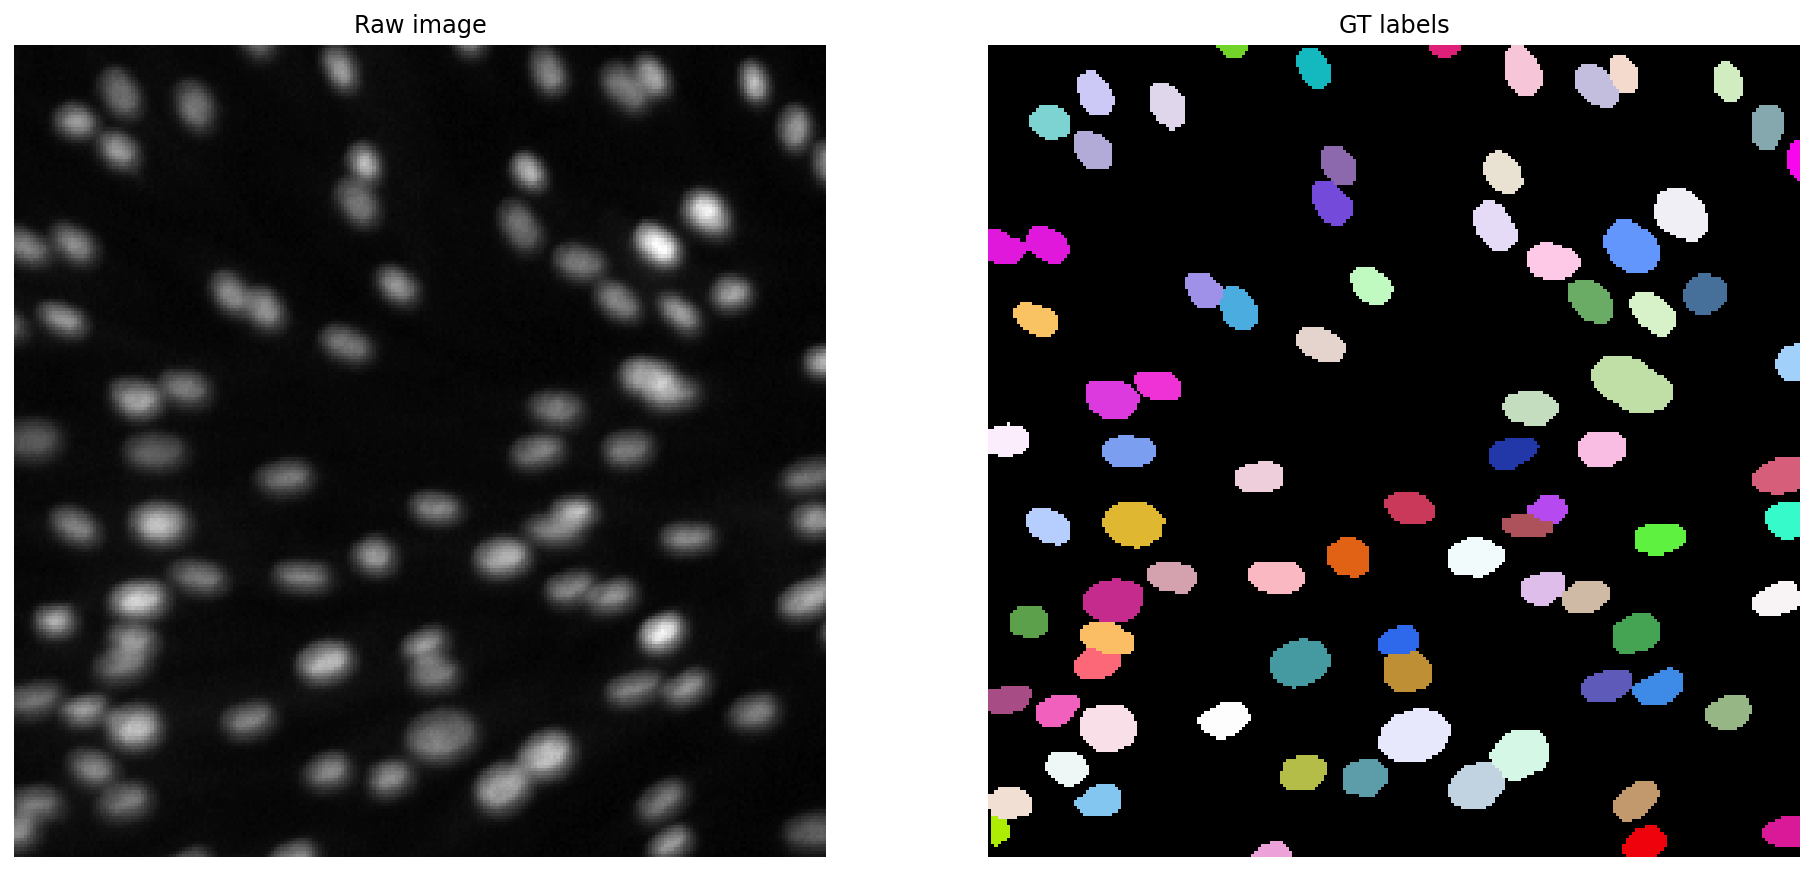

In [6]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

## Create Masks

In [7]:
def getM(Y):
    M=[]
    for file in tqdm(range(int(len(Y)))):
        objects=np.unique(Y[file])[1:]
        tmp=np.zeros_like(Y[file]).astype(np.float16)
        for objLabel in objects:
            Ypatch=(Y[file]==objLabel)
            edt = ndimage.distance_transform_edt(Ypatch).astype(np.float16)
            tmp+=edt/(np.max(edt)+1e-10)
        M.append(tmp)
    return M

In [8]:
# M_trn=getM(Y_trn)
# M_val=getM(Y_val)

# np.savez('/home/lalit/Desktop/04_Projects/stardistPytorch/data/M.npz', M_trn, M_val)

In [9]:
Mfile = np.load('data/M.npz', allow_pickle=True)
M_trn=Mfile['arr_0']
M_val=Mfile['arr_1']

In [10]:
def getPatches(X, Y, M):
    dataX_=[]
    dataY_=[]
    dataM_=[]
    ps=256
    for file in tqdm(range(int(len(X)))): 
        stepy=np.minimum(X[file].shape[0]-ps, ps//4)
        stepx=np.minimum(X[file].shape[1]-ps, ps//4)
        if(X[file].shape[0]==ps and X[file].shape[1]==ps):
            if(X[file].shape==(ps, ps)):
                dataX_.append(X[file][np.newaxis, ...])
                dataY_.append(Y[file][...])
                dataM_.append(M[file][np.newaxis, ...])
        elif(X[file].shape[0]==ps and X[file].shape[1]>ps):
            for x in range(0, X[file].shape[1], stepx):
                if(X[file][ :, x:x+ps].shape==(ps, ps)):
                    dataX_.append(X[file][np.newaxis, :, x:x+ps])
                    dataY_.append(Y[file][:, x:x+ps])
                    dataM_.append(M[file][np.newaxis, :, x:x+ps])
        elif(X[file].shape[0]>ps and X[file].shape[1]==ps):
            for y in range(0, X[file].shape[0], stepy):
                if(X[file][y:y+ps, :].shape==(ps, ps)):
                    dataX_.append(X[file][np.newaxis, y:y+ps, :])
                    dataY_.append(Y[file][y:y+ps, :])
                    dataM_.append(M[file][np.newaxis, y:y+ps, :])
        elif(X[file].shape[0]>ps and X[file].shape[1]>ps):
            for y in range(0, X[file].shape[0], stepy):
                for x in range(0, X[file].shape[1], stepx):
                    if(X[file][y:y+ps, x:x+ps].shape==(ps, ps)):
                        dataX_.append(X[file][np.newaxis, y:y+ps, x:x+ps])
                        dataY_.append(Y[file][y:y+ps, x:x+ps])
                        dataM_.append(M[file][np.newaxis, y:y+ps, x:x+ps])
    return np.array(dataX_), np.array(dataY_), np.array(dataM_)
        


In [11]:
dataXt, dataYt, dataMt=getPatches(X_trn, Y_trn, M_trn)
dataXv, dataYv, dataMv=getPatches(X_val, Y_val, M_val)

100%|██████████| 67/67 [00:00<00:00, 27634.81it/s]


In [12]:
Y_trn_dist=[np.moveaxis(star_dist(lbl, 32), 2, 0).astype(np.float16) for lbl in dataYt] # CYX
Y_val_dist=[np.moveaxis(star_dist(lbl, 32), 2, 0).astype(np.float16) for lbl in dataYv] # CYX

indt = 2727
indv = 327


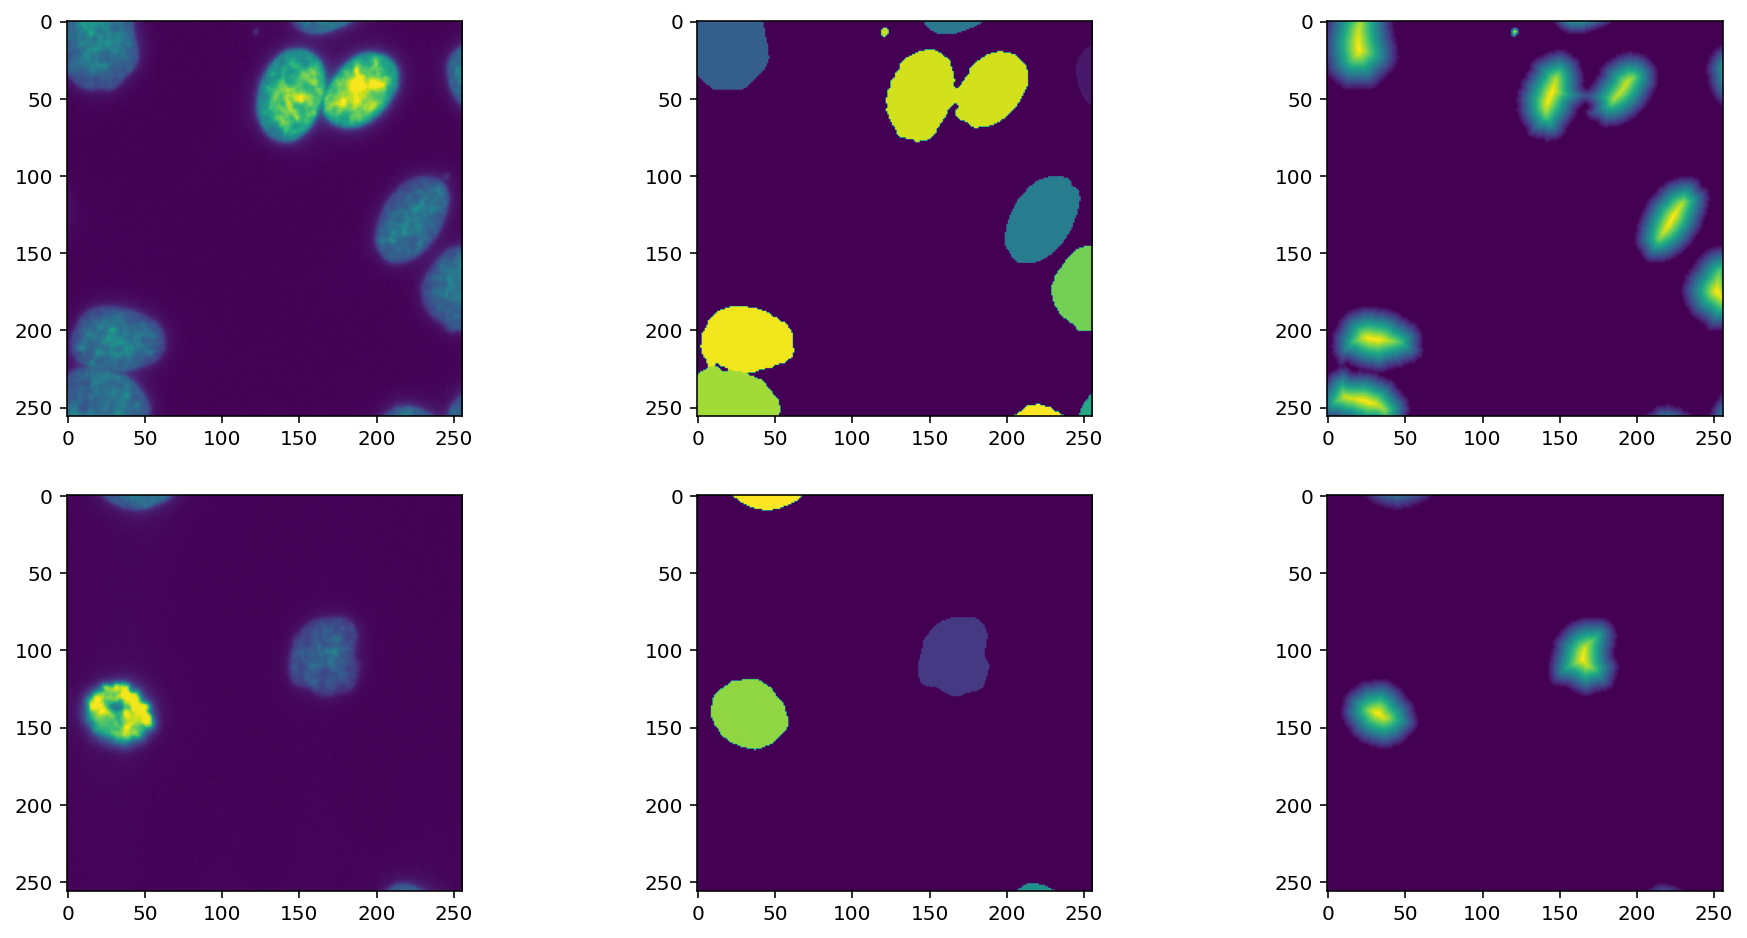

In [13]:
plt.figure(figsize=(16,8))
indt=np.random.randint(len(dataXt))
print("indt =", indt)
indv=np.random.randint(len(dataXv))
print("indv =", indv)
plt.subplot(2,3,1)
plt.imshow(dataXt[indt][0, ...])
plt.subplot(2,3,2)
plt.imshow(dataYt[indt][...])
plt.subplot(2,3,3)
plt.imshow(dataMt[indt][0, ...].astype(np.float32))
plt.subplot(2,3,4)
plt.imshow(dataXv[indv][0, ...])
plt.subplot(2,3,5)
plt.imshow(dataYv[indv][...])
plt.subplot(2,3,6)
plt.imshow(dataMv[indv][0, ...].astype(np.float32))


In [14]:
from stardistPytorch.unet.model import UNet
nRays = 32
net = UNet(nRays, depth=3)
from datetime import datetime
postfix = "dsb_"+str(nRays)+"_depth=3_"+str(datetime.now())
print(postfix)

dsb_32_depth=3_2020-03-30 02:14:21.915776


/home/lalit/Desktop/04_Projects/stardistPytorch2/stardistPytorch/unet/model.py:216: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/home/lalit/Desktop/04_Projects/stardistPytorch2/stardistPytorch/unet/model.py:217: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


In [15]:
miniBatchSize=4
stepsPerEpoch=100
valSize=dataXv.shape[0]//miniBatchSize

In [16]:
#TODO
# Do they use augmentation
# Is the number of patches extracted similar - overlapping?
# how do they handle grid
# shape completion is not implemented
# `self.train_foreground_only` how the patches should be sampled?
# check how stardist evaluates field of view! (implemented in the original training notebook)

# DONE
# they use a different normalization! (but it happens in notebook)
# `self.train_background_reg` what is the regularization aspect of this?

In [17]:
trainHist, valHist = trainNetwork(net = net, trainData = dataXt, valData = dataXv, 
                                           trainDataGT = np.array(Y_trn_dist), valDataGT = np.array(Y_val_dist), 
                                           trainDataMask = dataMt, valDataMask = dataMv,
                                           postfix = postfix, directory="models/", device = device, 
                                           verbose=False, numOfEpochs= 400, stepsPerEpoch=stepsPerEpoch,   
                                           miniBatchSize=miniBatchSize, learningRate=3e-4, 
                                           supervised=True, valSize=valSize)

/home/lalit/Desktop/01_Softwares/anaconda3/envs/stardistPytorchEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
100%|██████████| 100/100 [00:12<00:00,  7.99it/s]

Epoch 0 finished      
Avg. Loss in Epoch : 2.125523316860199+-(2SEM)0.1570998858257337      



100%|██████████| 144/144 [00:09<00:00, 14.82it/s]

Avg. Validation Loss in Epoch : 1.954445546699895+-(2SEM)0.040618308957064454      



100%|██████████| 100/100 [00:12<00:00,  7.75it/s]

Epoch 1 finished      
Avg. Loss in Epoch : 1.5450782150030136+-(2SEM)0.11080426009623594      



100%|██████████| 144/144 [00:09<00:00, 15.51it/s]

Avg. Validation Loss in Epoch : 1.560649237698979+-(2SEM)0.058716364598296766      



100%|██████████| 100/100 [00:13<00:00,  7.44it/s]

Epoch 2 finished      
Avg. Loss in Epoch : 1.36938560962677+-(2SEM)0.08080833676700949      



100%|██████████| 144/144 [00:09<00:00, 15.35it/s]

Avg. Validation Loss in Epoch : 1.4595477916300297+-(2SEM)0.05002625798418609      



100%|██████████| 100/100 [00:13<00:00,  7.36it/s]

Epoch 3 finished      
Avg. Loss in Epoch : 1.5322458863258361+-(2SEM)0.1101993531372426      



100%|██████████| 144/144 [00:08<00:00, 16.17it/s]

Avg. Validation Loss in Epoch : 1.4114705440070894+-(2SEM)0.033036094475711826      



100%|██████████| 100/100 [00:14<00:00,  6.85it/s]

Epoch 4 finished      
Avg. Loss in Epoch : 1.1184592884778977+-(2SEM)0.08580133740616011      



100%|██████████| 144/144 [00:08<00:00, 16.33it/s]

Avg. Validation Loss in Epoch : 1.0066743021210034+-(2SEM)0.040884146828531365      



100%|██████████| 100/100 [00:14<00:00,  6.74it/s]

Epoch 5 finished      
Avg. Loss in Epoch : 0.8347387486696243+-(2SEM)0.06258433144931125      



100%|██████████| 144/144 [00:08<00:00, 16.44it/s]

Avg. Validation Loss in Epoch : 0.9429220693806807+-(2SEM)0.04023622568944171      



100%|██████████| 100/100 [00:14<00:00,  6.91it/s]

Epoch 6 finished      
Avg. Loss in Epoch : 0.8855323761701583+-(2SEM)0.07752665715356356      



100%|██████████| 144/144 [00:09<00:00, 15.46it/s]

Avg. Validation Loss in Epoch : 0.9560542514340745+-(2SEM)0.06650613681666132      



100%|██████████| 100/100 [00:37<00:00,  2.68it/s]

Epoch 7 finished      
Avg. Loss in Epoch : 1.0377125564217566+-(2SEM)0.06748685590851242      



100%|██████████| 144/144 [00:08<00:00, 17.06it/s]

Avg. Validation Loss in Epoch : 1.0102141979667876+-(2SEM)0.05883268315282645      



100%|██████████| 100/100 [00:14<00:00,  6.95it/s]

Epoch 8 finished      
Avg. Loss in Epoch : 0.9298540878295899+-(2SEM)0.05242639601431387      



100%|██████████| 144/144 [00:08<00:00, 16.18it/s]

Avg. Validation Loss in Epoch : 0.8957728217873309+-(2SEM)0.02176461835324485      



100%|██████████| 100/100 [00:14<00:00,  6.93it/s]

Epoch 9 finished      
Avg. Loss in Epoch : 0.9361207962036133+-(2SEM)0.09104348478367377      



100%|██████████| 144/144 [00:08<00:00, 16.77it/s]

Avg. Validation Loss in Epoch : 0.9979728470659919+-(2SEM)0.078007844434792      



100%|██████████| 100/100 [00:14<00:00,  7.07it/s]

Epoch 10 finished      
Avg. Loss in Epoch : 0.955521851181984+-(2SEM)0.07298325832718432      



100%|██████████| 144/144 [00:08<00:00, 16.65it/s]

Avg. Validation Loss in Epoch : 0.9032692892683877+-(2SEM)0.025259136118472202      



100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Epoch 11 finished      
Avg. Loss in Epoch : 0.8338337436318397+-(2SEM)0.05708821625126094      



100%|██████████| 144/144 [00:09<00:00, 15.50it/s]

Avg. Validation Loss in Epoch : 0.8511044074677758+-(2SEM)0.05039113107728848      



100%|██████████| 100/100 [00:14<00:00,  7.11it/s]

Epoch 12 finished      
Avg. Loss in Epoch : 0.7857601988315582+-(2SEM)0.05899448976338948      



100%|██████████| 144/144 [00:08<00:00, 16.65it/s]

Avg. Validation Loss in Epoch : 0.83980260292689+-(2SEM)0.0482437625177077      



100%|██████████| 100/100 [00:14<00:00,  6.70it/s]

Epoch 13 finished      
Avg. Loss in Epoch : 0.6901657095551491+-(2SEM)0.03853793215085274      



100%|██████████| 144/144 [00:09<00:00, 14.77it/s]

Avg. Validation Loss in Epoch : 0.7651439449853368+-(2SEM)0.04448876801285546      



100%|██████████| 100/100 [00:13<00:00,  7.45it/s]

Epoch 14 finished      
Avg. Loss in Epoch : 0.7636536115407944+-(2SEM)0.06310067858440185      



100%|██████████| 144/144 [00:08<00:00, 16.99it/s]

Avg. Validation Loss in Epoch : 0.7749163015849061+-(2SEM)0.04233335551923032      



100%|██████████| 100/100 [00:26<00:00,  3.74it/s]

Epoch 15 finished      
Avg. Loss in Epoch : 0.8484356963634491+-(2SEM)0.05586141239954938      



100%|██████████| 144/144 [00:09<00:00, 15.22it/s]

Avg. Validation Loss in Epoch : 0.982617592646016+-(2SEM)0.0475799693347771      



100%|██████████| 100/100 [00:15<00:00,  6.57it/s]

Epoch 16 finished      
Avg. Loss in Epoch : 0.8313206279277802+-(2SEM)0.05306923188108329      



100%|██████████| 144/144 [00:08<00:00, 16.71it/s]

Avg. Validation Loss in Epoch : 0.7969013744344314+-(2SEM)0.03929743513312183      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 17 finished      
Avg. Loss in Epoch : 0.7383662098646164+-(2SEM)0.06309501587550485      



100%|██████████| 144/144 [00:09<00:00, 15.26it/s]

Avg. Validation Loss in Epoch : 0.7479592133313417+-(2SEM)0.038498523496971276      



100%|██████████| 100/100 [00:14<00:00,  6.72it/s]

Epoch 18 finished      
Avg. Loss in Epoch : 0.8850223910808563+-(2SEM)0.062340976315663876      



100%|██████████| 144/144 [00:08<00:00, 16.77it/s]

Avg. Validation Loss in Epoch : 0.9774248502734635+-(2SEM)0.06647531990932233      



100%|██████████| 100/100 [00:14<00:00,  7.05it/s]

Epoch 19 finished      
Avg. Loss in Epoch : 0.8002752082049847+-(2SEM)0.05584500938472916      



100%|██████████| 144/144 [00:08<00:00, 16.19it/s]

Avg. Validation Loss in Epoch : 0.7517243876225419+-(2SEM)0.03390077227993261      



100%|██████████| 100/100 [00:14<00:00,  7.04it/s]

Epoch 20 finished      
Avg. Loss in Epoch : 0.622278545498848+-(2SEM)0.047483515126635054      



100%|██████████| 144/144 [00:09<00:00, 15.67it/s]

Avg. Validation Loss in Epoch : 0.7138968435012631+-(2SEM)0.03303848025395536      



100%|██████████| 100/100 [00:14<00:00,  6.88it/s]

Epoch 21 finished      
Avg. Loss in Epoch : 0.6116068477928639+-(2SEM)0.03360995489692899      



100%|██████████| 144/144 [00:08<00:00, 16.65it/s]

Avg. Validation Loss in Epoch : 0.7021048290448056+-(2SEM)0.037813015426836655      



100%|██████████| 100/100 [00:14<00:00,  6.76it/s]

Epoch 22 finished      
Avg. Loss in Epoch : 0.7512196078896523+-(2SEM)0.054266125155417955      



100%|██████████| 144/144 [00:08<00:00, 16.42it/s]

Avg. Validation Loss in Epoch : 0.7375693134963512+-(2SEM)0.035018174314019324      



100%|██████████| 100/100 [00:25<00:00,  3.85it/s]

Epoch 23 finished      
Avg. Loss in Epoch : 0.674352902173996+-(2SEM)0.04143752530931434      



100%|██████████| 144/144 [00:08<00:00, 17.01it/s]

Avg. Validation Loss in Epoch : 0.8902516865895854+-(2SEM)0.06231187045906902      



100%|██████████| 100/100 [00:14<00:00,  6.98it/s]

Epoch 24 finished      
Avg. Loss in Epoch : 0.793285935819149+-(2SEM)0.05813974950179013      



100%|██████████| 144/144 [00:09<00:00, 14.90it/s]

Avg. Validation Loss in Epoch : 0.744605754605598+-(2SEM)0.039932075089509314      



100%|██████████| 100/100 [00:13<00:00,  7.38it/s]

Epoch 25 finished      
Avg. Loss in Epoch : 0.7025601282715798+-(2SEM)0.049630783792198624      



100%|██████████| 144/144 [00:09<00:00, 14.84it/s]

Avg. Validation Loss in Epoch : 0.6835517581138346+-(2SEM)0.031162567199172698      



100%|██████████| 100/100 [00:14<00:00,  6.69it/s]

Epoch 26 finished      
Avg. Loss in Epoch : 0.8276275759935379+-(2SEM)0.057194737241072956      



100%|██████████| 144/144 [00:08<00:00, 16.45it/s]

Avg. Validation Loss in Epoch : 0.6761878712309731+-(2SEM)0.031025902216660295      



100%|██████████| 100/100 [00:13<00:00,  7.40it/s]

Epoch 27 finished      
Avg. Loss in Epoch : 0.6542278614640236+-(2SEM)0.04413381247778779      



100%|██████████| 144/144 [00:09<00:00, 15.01it/s]

Avg. Validation Loss in Epoch : 0.6504055017398463+-(2SEM)0.033488204480448244      



100%|██████████| 100/100 [00:15<00:00,  6.53it/s]

Epoch 28 finished      
Avg. Loss in Epoch : 0.564593505859375+-(2SEM)0.0400754894965752      



100%|██████████| 144/144 [00:08<00:00, 16.96it/s]

Avg. Validation Loss in Epoch : 0.8372837934229109+-(2SEM)0.05401610426498518      



100%|██████████| 100/100 [00:16<00:00,  6.17it/s]

Epoch 29 finished      
Avg. Loss in Epoch : 0.5564373192191124+-(2SEM)0.04545337748901466      



100%|██████████| 144/144 [00:08<00:00, 16.31it/s]

Avg. Validation Loss in Epoch : 0.6059219290812811+-(2SEM)0.02921561701195302      



100%|██████████| 100/100 [00:14<00:00,  6.98it/s]

Epoch 30 finished      
Avg. Loss in Epoch : 0.6256519238650798+-(2SEM)0.03772571797674591      



100%|██████████| 144/144 [00:08<00:00, 16.83it/s]

Avg. Validation Loss in Epoch : 0.573189485197266+-(2SEM)0.02796092361474338      



100%|██████████| 100/100 [00:24<00:00,  4.02it/s]

Epoch 31 finished      
Avg. Loss in Epoch : 0.6027639003098011+-(2SEM)0.04845475921677375      



100%|██████████| 144/144 [00:08<00:00, 16.24it/s]

Avg. Validation Loss in Epoch : 0.6490430424196852+-(2SEM)0.023037837252982293      



100%|██████████| 100/100 [00:15<00:00,  6.44it/s]

Epoch 32 finished      
Avg. Loss in Epoch : 0.6973149117827415+-(2SEM)0.05125356085227607      



100%|██████████| 144/144 [00:09<00:00, 14.84it/s]

Avg. Validation Loss in Epoch : 0.7211290879382027+-(2SEM)0.029596202223356665      



100%|██████████| 100/100 [00:14<00:00,  7.13it/s]

Epoch 33 finished      
Avg. Loss in Epoch : 0.574763588309288+-(2SEM)0.033974491111702886      



100%|██████████| 144/144 [00:08<00:00, 16.85it/s]

Avg. Validation Loss in Epoch : 0.5711228002069725+-(2SEM)0.03017429532399454      



100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Epoch 34 finished      
Avg. Loss in Epoch : 0.6943625736236573+-(2SEM)0.061027401397026546      



100%|██████████| 144/144 [00:09<00:00, 15.48it/s]

Avg. Validation Loss in Epoch : 0.5346805329124132+-(2SEM)0.023382626297153375      



100%|██████████| 100/100 [00:13<00:00,  7.17it/s]

Epoch 35 finished      
Avg. Loss in Epoch : 0.574142439365387+-(2SEM)0.039940077438745336      



100%|██████████| 144/144 [00:09<00:00, 15.72it/s]

Avg. Validation Loss in Epoch : 0.5613457835796807+-(2SEM)0.02806384912436916      



100%|██████████| 100/100 [00:13<00:00,  7.54it/s]

Epoch 36 finished      
Avg. Loss in Epoch : 0.4806855300068855+-(2SEM)0.032246069290301264      



100%|██████████| 144/144 [00:09<00:00, 14.94it/s]

Avg. Validation Loss in Epoch : 0.5547630944185786+-(2SEM)0.034764650036808856      



100%|██████████| 100/100 [00:14<00:00,  7.04it/s]

Epoch 37 finished      
Avg. Loss in Epoch : 0.48945765376091005+-(2SEM)0.03952905800149467      



100%|██████████| 144/144 [00:09<00:00, 15.45it/s]

Avg. Validation Loss in Epoch : 0.5302448068848915+-(2SEM)0.030192131407225778      



100%|██████████| 100/100 [00:22<00:00,  4.49it/s]

Epoch 38 finished      
Avg. Loss in Epoch : 0.5618138562142849+-(2SEM)0.03497553158839127      



100%|██████████| 144/144 [00:08<00:00, 16.95it/s]

Avg. Validation Loss in Epoch : 0.5259803395925297+-(2SEM)0.02593508189344645      



100%|██████████| 100/100 [00:14<00:00,  6.91it/s]

Epoch 39 finished      
Avg. Loss in Epoch : 0.6151320044696331+-(2SEM)0.0435435153794049      



100%|██████████| 144/144 [00:09<00:00, 15.26it/s]

Avg. Validation Loss in Epoch : 0.6088527116096683+-(2SEM)0.024190096508096406      



100%|██████████| 100/100 [00:14<00:00,  6.93it/s]

Epoch 40 finished      
Avg. Loss in Epoch : 0.5804642987251282+-(2SEM)0.04122252506052561      



100%|██████████| 144/144 [00:08<00:00, 16.51it/s]

Avg. Validation Loss in Epoch : 0.6255648326542642+-(2SEM)0.04205098543302661      



100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Epoch 41 finished      
Avg. Loss in Epoch : 0.6072802451252938+-(2SEM)0.06120932831280477      



100%|██████████| 144/144 [00:08<00:00, 16.51it/s]

Avg. Validation Loss in Epoch : 0.6355210246725215+-(2SEM)0.03261917881265155      



100%|██████████| 100/100 [00:14<00:00,  6.88it/s]

Epoch 42 finished      
Avg. Loss in Epoch : 0.5907913206517696+-(2SEM)0.04185917989963121      



100%|██████████| 144/144 [00:09<00:00, 14.84it/s]

Avg. Validation Loss in Epoch : 0.498763260535068+-(2SEM)0.02601182438100655      



100%|██████████| 100/100 [00:14<00:00,  6.84it/s]

Epoch 43 finished      
Avg. Loss in Epoch : 0.48575972199440004+-(2SEM)0.032848035331736344      



100%|██████████| 144/144 [00:09<00:00, 14.70it/s]

Avg. Validation Loss in Epoch : 0.5916255853242345+-(2SEM)0.02750477808365201      



100%|██████████| 100/100 [00:15<00:00,  6.59it/s]

Epoch 44 finished      
Avg. Loss in Epoch : 0.4462358620762825+-(2SEM)0.027702843953801876      



100%|██████████| 144/144 [00:08<00:00, 16.32it/s]

Avg. Validation Loss in Epoch : 0.4977253136328525+-(2SEM)0.030941212688960374      



100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Epoch 45 finished      
Avg. Loss in Epoch : 0.4835320881009102+-(2SEM)0.040543921257030074      



100%|██████████| 144/144 [00:09<00:00, 15.94it/s]

Avg. Validation Loss in Epoch : 0.48238945679946077+-(2SEM)0.027863792518074262      



100%|██████████| 100/100 [00:25<00:00,  3.86it/s]

Epoch 46 finished      
Avg. Loss in Epoch : 0.5543884144723416+-(2SEM)0.035985362988131396      



100%|██████████| 144/144 [00:09<00:00, 15.21it/s]

Avg. Validation Loss in Epoch : 0.49870198913332486+-(2SEM)0.020928699057508104      



100%|██████████| 100/100 [00:15<00:00,  6.52it/s]

Epoch 47 finished      
Avg. Loss in Epoch : 0.5851515553891659+-(2SEM)0.04372373897658054      



100%|██████████| 144/144 [00:08<00:00, 16.48it/s]

Avg. Validation Loss in Epoch : 0.5523457910037703+-(2SEM)0.03337018279981974      



100%|██████████| 100/100 [00:14<00:00,  6.84it/s]

Epoch 48 finished      
Avg. Loss in Epoch : 0.49756386786699297+-(2SEM)0.03930579337773117      



100%|██████████| 144/144 [00:08<00:00, 16.63it/s]

Avg. Validation Loss in Epoch : 0.46634243470099235+-(2SEM)0.023643876787637876      



100%|██████████| 100/100 [00:14<00:00,  6.71it/s]

Epoch 49 finished      
Avg. Loss in Epoch : 0.6177802103757858+-(2SEM)0.053553510888813806      



100%|██████████| 144/144 [00:08<00:00, 16.35it/s]

Avg. Validation Loss in Epoch : 0.5534800516648425+-(2SEM)0.02899541254196702      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 50 finished      
Avg. Loss in Epoch : 0.5502879990637303+-(2SEM)0.04144403791541955      



100%|██████████| 144/144 [00:09<00:00, 15.21it/s]

Avg. Validation Loss in Epoch : 0.5619267123854823+-(2SEM)0.027835384841911174      



100%|██████████| 100/100 [00:15<00:00,  6.45it/s]

Epoch 51 finished      
Avg. Loss in Epoch : 0.4190691545605659+-(2SEM)0.033070926947930714      



100%|██████████| 144/144 [00:08<00:00, 16.08it/s]

Avg. Validation Loss in Epoch : 0.4685579472117954+-(2SEM)0.027726529266718546      



100%|██████████| 100/100 [00:15<00:00,  6.52it/s]

Epoch 52 finished      
Avg. Loss in Epoch : 0.433931078761816+-(2SEM)0.029361827733610946      



100%|██████████| 144/144 [00:09<00:00, 15.93it/s]

Avg. Validation Loss in Epoch : 0.45590428614781964+-(2SEM)0.027331850034504102      



100%|██████████| 100/100 [00:14<00:00,  6.99it/s]

Epoch 53 finished      
Avg. Loss in Epoch : 0.5074436844885349+-(2SEM)0.042696755193239025      



100%|██████████| 144/144 [00:08<00:00, 16.79it/s]

Avg. Validation Loss in Epoch : 0.5188105787254043+-(2SEM)0.021669088097724245      



100%|██████████| 100/100 [00:22<00:00,  4.47it/s]

Epoch 54 finished      
Avg. Loss in Epoch : 0.4988283808529377+-(2SEM)0.031812823221334025      



100%|██████████| 144/144 [00:08<00:00, 16.40it/s]

Avg. Validation Loss in Epoch : 0.49038303250239956+-(2SEM)0.026317093719193413      



100%|██████████| 100/100 [00:15<00:00,  6.44it/s]

Epoch 55 finished      
Avg. Loss in Epoch : 0.5798028747737408+-(2SEM)0.04553517756396268      



100%|██████████| 144/144 [00:09<00:00, 15.76it/s]

Avg. Validation Loss in Epoch : 0.4713137314344446+-(2SEM)0.02297554793295366      



100%|██████████| 100/100 [00:14<00:00,  7.13it/s]

Epoch 56 finished      
Avg. Loss in Epoch : 0.4876386547088623+-(2SEM)0.03642816844789224      



100%|██████████| 144/144 [00:09<00:00, 15.14it/s]

Avg. Validation Loss in Epoch : 0.4938832428306341+-(2SEM)0.024787146211732267      



100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Epoch 57 finished      
Avg. Loss in Epoch : 0.6159165921807289+-(2SEM)0.047707289768730225      



100%|██████████| 144/144 [00:09<00:00, 14.47it/s]

Avg. Validation Loss in Epoch : 0.4831882155396872+-(2SEM)0.027009421369075443      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 58 finished      
Avg. Loss in Epoch : 0.4806883418560028+-(2SEM)0.03609913917517783      



100%|██████████| 144/144 [00:08<00:00, 16.35it/s]

Avg. Validation Loss in Epoch : 0.4888100553717878+-(2SEM)0.031657015912831335      



100%|██████████| 100/100 [00:14<00:00,  7.12it/s]

Epoch 59 finished      
Avg. Loss in Epoch : 0.42921004593372347+-(2SEM)0.033998283590692915      



100%|██████████| 144/144 [00:09<00:00, 15.95it/s]

Avg. Validation Loss in Epoch : 0.46643865832851994+-(2SEM)0.026197516394024224      



100%|██████████| 100/100 [00:15<00:00,  6.32it/s]

Epoch 60 finished      
Avg. Loss in Epoch : 0.4216349329054356+-(2SEM)0.03408416547146889      



100%|██████████| 144/144 [00:08<00:00, 16.09it/s]

Avg. Validation Loss in Epoch : 0.4709071402127544+-(2SEM)0.025511317901609803      



100%|██████████| 100/100 [00:14<00:00,  6.71it/s]

Epoch 61 finished      
Avg. Loss in Epoch : 0.48908325970172883+-(2SEM)0.03284165394249321      



100%|██████████| 144/144 [00:09<00:00, 15.51it/s]

Avg. Validation Loss in Epoch : 0.45470937631196445+-(2SEM)0.020808114277026706      



100%|██████████| 100/100 [00:23<00:00,  4.20it/s]

Epoch 62 finished      
Avg. Loss in Epoch : 0.4634945732355118+-(2SEM)0.03141975170708959      



100%|██████████| 144/144 [00:10<00:00, 14.35it/s]

Avg. Validation Loss in Epoch : 0.5034356312826276+-(2SEM)0.026429625562956163      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 63 finished      
Avg. Loss in Epoch : 0.5663734962046146+-(2SEM)0.03750441293154484      



100%|██████████| 144/144 [00:09<00:00, 15.93it/s]

Avg. Validation Loss in Epoch : 0.8996577515370316+-(2SEM)0.06900151604889847      



100%|██████████| 100/100 [00:13<00:00,  7.43it/s]

Epoch 64 finished      
Avg. Loss in Epoch : 0.47551146686077117+-(2SEM)0.035738939315202466      



100%|██████████| 144/144 [00:09<00:00, 14.71it/s]

Avg. Validation Loss in Epoch : 0.4817669925590356+-(2SEM)0.02448989386233631      



100%|██████████| 100/100 [00:15<00:00,  6.65it/s]

Epoch 65 finished      
Avg. Loss in Epoch : 0.5270424157381057+-(2SEM)0.04782549531307696      



100%|██████████| 144/144 [00:08<00:00, 16.22it/s]

Avg. Validation Loss in Epoch : 0.43345858881043065+-(2SEM)0.021370475450527573      



100%|██████████| 100/100 [00:14<00:00,  7.01it/s]

Epoch 66 finished      
Avg. Loss in Epoch : 0.4757812508940697+-(2SEM)0.03462260753766574      



100%|██████████| 144/144 [00:09<00:00, 15.43it/s]

Avg. Validation Loss in Epoch : 0.5145543082099822+-(2SEM)0.024913674314250716      



100%|██████████| 100/100 [00:15<00:00,  6.64it/s]

Epoch 67 finished      
Avg. Loss in Epoch : 0.3863484437763691+-(2SEM)0.024282342715927614      



100%|██████████| 144/144 [00:08<00:00, 16.01it/s]

Avg. Validation Loss in Epoch : 0.4744999956132637+-(2SEM)0.029854963178910555      



100%|██████████| 100/100 [00:15<00:00,  6.64it/s]

Epoch 68 finished      
Avg. Loss in Epoch : 0.39901488840579985+-(2SEM)0.031411930833113756      



100%|██████████| 144/144 [00:09<00:00, 15.73it/s]

Avg. Validation Loss in Epoch : 0.4486862298929029+-(2SEM)0.0258955091085778      



100%|██████████| 100/100 [00:27<00:00,  3.62it/s]

Epoch 69 finished      
Avg. Loss in Epoch : 0.45065727934241295+-(2SEM)0.029158475733062232      



100%|██████████| 144/144 [00:08<00:00, 16.57it/s]

Avg. Validation Loss in Epoch : 0.4806200077550279+-(2SEM)0.025726976310415334      



100%|██████████| 100/100 [00:13<00:00,  7.49it/s]

Epoch 70 finished      
Avg. Loss in Epoch : 0.49600995033979417+-(2SEM)0.03157484477412594      



100%|██████████| 144/144 [00:10<00:00, 14.35it/s]

Avg. Validation Loss in Epoch : 0.4702093865101536+-(2SEM)0.02204791132317892      



100%|██████████| 100/100 [00:15<00:00,  6.31it/s]

Epoch 71 finished      
Avg. Loss in Epoch : 0.5144846054911614+-(2SEM)0.03662026363569189      



100%|██████████| 144/144 [00:09<00:00, 14.46it/s]

Avg. Validation Loss in Epoch : 0.5108696251279778+-(2SEM)0.03212975407419596      



100%|██████████| 100/100 [00:13<00:00,  7.18it/s]

Epoch 72 finished      
Avg. Loss in Epoch : 0.4866693916916847+-(2SEM)0.05043406386667204      



100%|██████████| 144/144 [00:09<00:00, 15.79it/s]

Avg. Validation Loss in Epoch : 0.580382452863786+-(2SEM)0.03080851628532162      



100%|██████████| 100/100 [00:15<00:00,  6.45it/s]

Epoch 73 finished      
Avg. Loss in Epoch : 0.507111150175333+-(2SEM)0.03809644273512794      



100%|██████████| 144/144 [00:09<00:00, 15.16it/s]

Avg. Validation Loss in Epoch : 0.42044160835858846+-(2SEM)0.021992687647654694      



100%|██████████| 100/100 [00:14<00:00,  6.76it/s]

Epoch 74 finished      
Avg. Loss in Epoch : 0.4161494114995003+-(2SEM)0.030021130014169145      



100%|██████████| 144/144 [00:08<00:00, 16.16it/s]

Avg. Validation Loss in Epoch : 0.42619923864387804+-(2SEM)0.024388876767845777      



100%|██████████| 100/100 [00:15<00:00,  6.53it/s]

Epoch 75 finished      
Avg. Loss in Epoch : 0.38729425430297854+-(2SEM)0.026308304341449002      



100%|██████████| 144/144 [00:09<00:00, 14.75it/s]

Avg. Validation Loss in Epoch : 0.4178634276613593+-(2SEM)0.025210675677500318      



100%|██████████| 100/100 [00:16<00:00,  6.21it/s]

Epoch 76 finished      
Avg. Loss in Epoch : 0.3999395518004894+-(2SEM)0.03331060044500187      



100%|██████████| 144/144 [00:08<00:00, 16.18it/s]

Avg. Validation Loss in Epoch : 0.4341279822919104+-(2SEM)0.022914896709566618      



100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

Epoch 77 finished      
Avg. Loss in Epoch : 0.4747350135445595+-(2SEM)0.03108243328490759      



100%|██████████| 144/144 [00:08<00:00, 16.54it/s]

Avg. Validation Loss in Epoch : 0.4994225704835521+-(2SEM)0.01570774713122067      



100%|██████████| 100/100 [00:15<00:00,  6.46it/s]

Epoch 78 finished      
Avg. Loss in Epoch : 0.5129592257738114+-(2SEM)0.03538512365147597      



100%|██████████| 144/144 [00:08<00:00, 16.35it/s]

Avg. Validation Loss in Epoch : 0.54287291618271+-(2SEM)0.03659777074858856      



100%|██████████| 100/100 [00:14<00:00,  6.84it/s]

Epoch 79 finished      
Avg. Loss in Epoch : 0.440643642693758+-(2SEM)0.03608028387568498      



100%|██████████| 144/144 [00:08<00:00, 16.42it/s]

Avg. Validation Loss in Epoch : 0.4480736883771088+-(2SEM)0.023748393789942184      



100%|██████████| 100/100 [00:14<00:00,  6.85it/s]

Epoch 80 finished      
Avg. Loss in Epoch : 0.5154098907113075+-(2SEM)0.04357076610607448      



100%|██████████| 144/144 [00:08<00:00, 16.25it/s]

Avg. Validation Loss in Epoch : 0.4289255017000768+-(2SEM)0.023293031331771713      



100%|██████████| 100/100 [00:14<00:00,  7.12it/s]

Epoch 81 finished      
Avg. Loss in Epoch : 0.4575130708515644+-(2SEM)0.035974749138296944      



100%|██████████| 144/144 [00:09<00:00, 15.68it/s]

Avg. Validation Loss in Epoch : 0.4519901835463113+-(2SEM)0.022761947604378222      



100%|██████████| 100/100 [00:15<00:00,  6.65it/s]

Epoch 82 finished      
Avg. Loss in Epoch : 0.36440377935767176+-(2SEM)0.02686272099547248      



100%|██████████| 144/144 [00:09<00:00, 15.99it/s]

Avg. Validation Loss in Epoch : 0.41589649332066375+-(2SEM)0.0257788609629932      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 83 finished      
Avg. Loss in Epoch : 0.37350078657269475+-(2SEM)0.02558955033614601      



100%|██████████| 144/144 [00:09<00:00, 15.45it/s]

Avg. Validation Loss in Epoch : 0.4013340271388491+-(2SEM)0.024245331522846275      



100%|██████████| 100/100 [00:14<00:00,  7.14it/s]

Epoch 84 finished      
Avg. Loss in Epoch : 0.4309655621647835+-(2SEM)0.03647286313376873      



100%|██████████| 144/144 [00:09<00:00, 14.79it/s]

Avg. Validation Loss in Epoch : 0.42630486749112606+-(2SEM)0.022196467435779077      



100%|██████████| 100/100 [00:24<00:00,  4.10it/s]

Epoch 85 finished      
Avg. Loss in Epoch : 0.440516976416111+-(2SEM)0.0268794751727656      



100%|██████████| 144/144 [00:09<00:00, 15.41it/s]

Avg. Validation Loss in Epoch : 0.4723642964123024+-(2SEM)0.029490655483574196      



100%|██████████| 100/100 [00:13<00:00,  7.33it/s]

Epoch 86 finished      
Avg. Loss in Epoch : 0.5130048803985119+-(2SEM)0.039360031625161586      



100%|██████████| 144/144 [00:08<00:00, 16.17it/s]

Avg. Validation Loss in Epoch : 0.5073960516601801+-(2SEM)0.027902768500302374      



100%|██████████| 100/100 [00:13<00:00,  7.19it/s]

Epoch 87 finished      
Avg. Loss in Epoch : 0.42279468804597853+-(2SEM)0.03106117448149568      



100%|██████████| 144/144 [00:09<00:00, 14.95it/s]

Avg. Validation Loss in Epoch : 0.5806155767705705+-(2SEM)0.02607305889617363      



100%|██████████| 100/100 [00:14<00:00,  6.69it/s]

Epoch 88 finished      
Avg. Loss in Epoch : 0.5352673411369324+-(2SEM)0.042247077530221014      



100%|██████████| 144/144 [00:08<00:00, 16.47it/s]

Avg. Validation Loss in Epoch : 0.43255366053846145+-(2SEM)0.02099915782238117      



100%|██████████| 100/100 [00:15<00:00,  6.58it/s]

Epoch 89 finished      
Avg. Loss in Epoch : 0.4228915940225124+-(2SEM)0.03320535620297886      



100%|██████████| 144/144 [00:09<00:00, 14.92it/s]

Avg. Validation Loss in Epoch : 0.4494571652677324+-(2SEM)0.0293815291734162      



100%|██████████| 100/100 [00:15<00:00,  6.47it/s]

Epoch 90 finished      
Avg. Loss in Epoch : 0.38043042942881583+-(2SEM)0.029863191505255664      



100%|██████████| 144/144 [00:09<00:00, 15.21it/s]

Avg. Validation Loss in Epoch : 0.3933323614506258+-(2SEM)0.021591565411888804      



100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Epoch 91 finished      
Avg. Loss in Epoch : 0.3619895803928375+-(2SEM)0.02533647614272746      



100%|██████████| 144/144 [00:09<00:00, 14.53it/s]

Avg. Validation Loss in Epoch : 0.43325225263834+-(2SEM)0.025721075483672636      



100%|██████████| 100/100 [00:15<00:00,  6.48it/s]

Epoch 92 finished      
Avg. Loss in Epoch : 0.4283796869218349+-(2SEM)0.029839114568827107      



100%|██████████| 144/144 [00:09<00:00, 15.73it/s]

Avg. Validation Loss in Epoch : 0.40578334292189944+-(2SEM)0.020391094677695815      



100%|██████████| 100/100 [00:27<00:00,  3.66it/s]

Epoch 93 finished      
Avg. Loss in Epoch : 0.41176766619086264+-(2SEM)0.027529496018549305      



100%|██████████| 144/144 [00:09<00:00, 14.45it/s]

Avg. Validation Loss in Epoch : 0.4770466845689548+-(2SEM)0.020334273332605173      



100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Epoch 94 finished      
Avg. Loss in Epoch : 0.5144576075673103+-(2SEM)0.03289539599934832      



100%|██████████| 144/144 [00:09<00:00, 14.95it/s]

Avg. Validation Loss in Epoch : 0.5007731240863601+-(2SEM)0.031191543748668893      



100%|██████████| 100/100 [00:14<00:00,  6.91it/s]

Epoch 95 finished      
Avg. Loss in Epoch : 0.4160018701851368+-(2SEM)0.029009749847453352      



100%|██████████| 144/144 [00:09<00:00, 15.35it/s]

Avg. Validation Loss in Epoch : 0.43316225666138863+-(2SEM)0.023360914487686717      



100%|██████████| 100/100 [00:14<00:00,  6.84it/s]

Epoch 96 finished      
Avg. Loss in Epoch : 0.46187193304300306+-(2SEM)0.04716431265667837      



100%|██████████| 144/144 [00:09<00:00, 14.47it/s]

Avg. Validation Loss in Epoch : 0.42313443765872055+-(2SEM)0.022019975205161992      



100%|██████████| 100/100 [00:14<00:00,  7.12it/s]

Epoch 97 finished      
Avg. Loss in Epoch : 0.4382261860370636+-(2SEM)0.03169962294221572      



100%|██████████| 144/144 [00:08<00:00, 16.52it/s]

Avg. Validation Loss in Epoch : 0.4351020566084319+-(2SEM)0.02340735708614611      



100%|██████████| 100/100 [00:14<00:00,  6.82it/s]

Epoch 98 finished      
Avg. Loss in Epoch : 0.35462833642959596+-(2SEM)0.02504223104157527      



100%|██████████| 144/144 [00:09<00:00, 15.88it/s]

Avg. Validation Loss in Epoch : 0.4170629050996568+-(2SEM)0.025008659832973276      



100%|██████████| 100/100 [00:15<00:00,  6.62it/s]

Epoch 99 finished      
Avg. Loss in Epoch : 0.366644199937582+-(2SEM)0.029916456573469325      



100%|██████████| 144/144 [00:09<00:00, 15.73it/s]

Avg. Validation Loss in Epoch : 0.40377519372850657+-(2SEM)0.022783405093707406      



100%|██████████| 100/100 [00:26<00:00,  3.78it/s]

Epoch 100 finished      
Avg. Loss in Epoch : 0.40352256670594217+-(2SEM)0.026342558995109438      



100%|██████████| 144/144 [00:08<00:00, 16.42it/s]

Avg. Validation Loss in Epoch : 0.38820366985681987+-(2SEM)0.021551406322562413      



100%|██████████| 100/100 [00:14<00:00,  6.69it/s]

Epoch 101 finished      
Avg. Loss in Epoch : 0.44488068893551824+-(2SEM)0.02759162479698955      



100%|██████████| 144/144 [00:09<00:00, 15.61it/s]

Avg. Validation Loss in Epoch : 0.5596149740740657+-(2SEM)0.03753875864574912      



100%|██████████| 100/100 [00:14<00:00,  6.78it/s]

Epoch 102 finished      
Avg. Loss in Epoch : 0.4815893641114235+-(2SEM)0.0333234293136518      



100%|██████████| 144/144 [00:09<00:00, 15.47it/s]

Avg. Validation Loss in Epoch : 0.5184498976709114+-(2SEM)0.03814573007740198      



100%|██████████| 100/100 [00:14<00:00,  6.75it/s]

Epoch 103 finished      
Avg. Loss in Epoch : 0.40486746802926066+-(2SEM)0.03572091340913287      



100%|██████████| 144/144 [00:09<00:00, 15.18it/s]

Avg. Validation Loss in Epoch : 0.41408967185351586+-(2SEM)0.020464831571024873      



100%|██████████| 100/100 [00:15<00:00,  6.47it/s]

Epoch 104 finished      
Avg. Loss in Epoch : 0.4784676131606102+-(2SEM)0.04120515269420381      



100%|██████████| 144/144 [00:09<00:00, 15.46it/s]

Avg. Validation Loss in Epoch : 0.3984147649672296+-(2SEM)0.02287053281439193      



100%|██████████| 100/100 [00:14<00:00,  7.14it/s]

Epoch 105 finished      
Avg. Loss in Epoch : 0.3681142318248749+-(2SEM)0.022305966520722795      



100%|██████████| 144/144 [00:09<00:00, 15.16it/s]

Avg. Validation Loss in Epoch : 0.39291304091198576+-(2SEM)0.022554104327556432      



100%|██████████| 100/100 [00:14<00:00,  6.85it/s]

Epoch 106 finished      
Avg. Loss in Epoch : 0.3429607927799225+-(2SEM)0.022644354634688727      



100%|██████████| 144/144 [00:09<00:00, 15.46it/s]

Avg. Validation Loss in Epoch : 0.3863085526973009+-(2SEM)0.02192114081126563      



100%|██████████| 100/100 [00:13<00:00,  7.43it/s]

Epoch 107 finished      
Avg. Loss in Epoch : 0.3430697743594646+-(2SEM)0.026545241105166324      



100%|██████████| 144/144 [00:08<00:00, 16.45it/s]

Avg. Validation Loss in Epoch : 0.4106997483306461+-(2SEM)0.019291013747752432      



100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

Epoch 108 finished      
Avg. Loss in Epoch : 0.417664929330349+-(2SEM)0.025621422802409866      



100%|██████████| 144/144 [00:09<00:00, 15.47it/s]

Avg. Validation Loss in Epoch : 0.42601198858271044+-(2SEM)0.02237158374206426      



100%|██████████| 100/100 [00:14<00:00,  6.82it/s]

Epoch 109 finished      
Avg. Loss in Epoch : 0.4663800883293152+-(2SEM)0.031957891459726225      



100%|██████████| 144/144 [00:08<00:00, 16.40it/s]

Avg. Validation Loss in Epoch : 0.7824705173778865+-(2SEM)0.048932094199190736      



100%|██████████| 100/100 [00:14<00:00,  6.98it/s]

Epoch 110 finished      
Avg. Loss in Epoch : 0.41475987777113915+-(2SEM)0.03271978082114297      



100%|██████████| 144/144 [00:08<00:00, 16.19it/s]

Avg. Validation Loss in Epoch : 0.3940165899693966+-(2SEM)0.02158113409864415      



100%|██████████| 100/100 [00:13<00:00,  7.43it/s]

Epoch 111 finished      
Avg. Loss in Epoch : 0.45841949209570887+-(2SEM)0.03826764771529328      



100%|██████████| 144/144 [00:09<00:00, 15.81it/s]

Avg. Validation Loss in Epoch : 0.42517626088940436+-(2SEM)0.024373879112473015      



100%|██████████| 100/100 [00:14<00:00,  6.84it/s]

Epoch 112 finished      
Avg. Loss in Epoch : 0.40555364072322847+-(2SEM)0.032277185430935766      



100%|██████████| 144/144 [00:08<00:00, 16.74it/s]

Avg. Validation Loss in Epoch : 0.38759490557842785+-(2SEM)0.020702151189725054      



100%|██████████| 100/100 [00:14<00:00,  7.09it/s]

Epoch 113 finished      
Avg. Loss in Epoch : 0.3439520397782326+-(2SEM)0.024475992862374042      



100%|██████████| 144/144 [00:08<00:00, 16.10it/s]

Avg. Validation Loss in Epoch : 0.38665172964748407+-(2SEM)0.02301337419476578      



100%|██████████| 100/100 [00:16<00:00,  6.24it/s]

Epoch 114 finished      
Avg. Loss in Epoch : 0.33367834240198135+-(2SEM)0.022339710897113094      



100%|██████████| 144/144 [00:08<00:00, 16.92it/s]

Avg. Validation Loss in Epoch : 0.37328110314491725+-(2SEM)0.022813083151106365      



100%|██████████| 100/100 [00:13<00:00,  7.25it/s]

Epoch 115 finished      
Avg. Loss in Epoch : 0.3684043978154659+-(2SEM)0.02875356780340783      



100%|██████████| 144/144 [00:09<00:00, 15.85it/s]

Avg. Validation Loss in Epoch : 0.39235349537597763+-(2SEM)0.02006952002166226      



100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

Epoch 116 finished      
Avg. Loss in Epoch : 0.4098112834990025+-(2SEM)0.0258210011378427      



100%|██████████| 144/144 [00:08<00:00, 16.69it/s]

Avg. Validation Loss in Epoch : 0.40913472655746674+-(2SEM)0.018797260796427306      



100%|██████████| 100/100 [00:14<00:00,  6.72it/s]

Epoch 117 finished      
Avg. Loss in Epoch : 0.45492505848407744+-(2SEM)0.03540202835482942      



100%|██████████| 144/144 [00:09<00:00, 14.72it/s]

Avg. Validation Loss in Epoch : 0.48366480393128264+-(2SEM)0.027340437249474093      



100%|██████████| 100/100 [00:14<00:00,  6.88it/s]

Epoch 118 finished      
Avg. Loss in Epoch : 0.391950389444828+-(2SEM)0.02850175919957366      



100%|██████████| 144/144 [00:10<00:00, 14.29it/s]

Avg. Validation Loss in Epoch : 0.36903396776566905+-(2SEM)0.020216477176813807      



100%|██████████| 100/100 [00:14<00:00,  6.85it/s]

Epoch 119 finished      
Avg. Loss in Epoch : 0.4632753837108612+-(2SEM)0.03428190210460995      



100%|██████████| 144/144 [00:09<00:00, 15.08it/s]

Avg. Validation Loss in Epoch : 0.3879192018260558+-(2SEM)0.020291222126329788      



100%|██████████| 100/100 [00:14<00:00,  6.85it/s]

Epoch 120 finished      
Avg. Loss in Epoch : 0.39781887978315356+-(2SEM)0.03072238475141232      



100%|██████████| 144/144 [00:09<00:00, 15.16it/s]

Avg. Validation Loss in Epoch : 0.419748618060516+-(2SEM)0.02503899615326741      



100%|██████████| 100/100 [00:15<00:00,  6.62it/s]

Epoch 121 finished      
Avg. Loss in Epoch : 0.33775468319654467+-(2SEM)0.026573876964400122      



100%|██████████| 144/144 [00:09<00:00, 14.89it/s]

Avg. Validation Loss in Epoch : 0.37239286365608376+-(2SEM)0.022170539667439915      



100%|██████████| 100/100 [00:14<00:00,  7.13it/s]

Epoch 122 finished      
Avg. Loss in Epoch : 0.32586400121450426+-(2SEM)0.02300854870146716      



100%|██████████| 144/144 [00:09<00:00, 14.64it/s]

Avg. Validation Loss in Epoch : 0.39345472068008447+-(2SEM)0.020501254404796092      



100%|██████████| 100/100 [00:14<00:00,  7.05it/s]

Epoch 123 finished      
Avg. Loss in Epoch : 0.38896008893847467+-(2SEM)0.027105388297007087      



100%|██████████| 144/144 [00:09<00:00, 15.99it/s]

Avg. Validation Loss in Epoch : 0.39947289176699186+-(2SEM)0.017782830741057607      



100%|██████████| 100/100 [00:24<00:00,  4.12it/s]

Epoch 124 finished      
Avg. Loss in Epoch : 0.36994047969579696+-(2SEM)0.023498278723972785      



100%|██████████| 144/144 [00:09<00:00, 14.82it/s]

Avg. Validation Loss in Epoch : 0.430257316885723+-(2SEM)0.02996942955819014      



100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Epoch 125 finished      
Avg. Loss in Epoch : 0.47852849796414376+-(2SEM)0.031691340555981266      



100%|██████████| 144/144 [00:09<00:00, 15.72it/s]

Avg. Validation Loss in Epoch : 0.40510046751134926+-(2SEM)0.021324100803215437      



100%|██████████| 100/100 [00:14<00:00,  6.77it/s]

Epoch 126 finished      
Avg. Loss in Epoch : 0.38299682080745695+-(2SEM)0.024526390947506648      



100%|██████████| 144/144 [00:09<00:00, 14.52it/s]

Avg. Validation Loss in Epoch : 0.4093332082654039+-(2SEM)0.022126593519543537      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 127 finished      
Avg. Loss in Epoch : 0.4200178214907646+-(2SEM)0.03510691787496533      



100%|██████████| 144/144 [00:09<00:00, 15.58it/s]

Avg. Validation Loss in Epoch : 0.408131690385441+-(2SEM)0.02164592371281826      



100%|██████████| 100/100 [00:14<00:00,  6.80it/s]

Epoch 128 finished      
Avg. Loss in Epoch : 0.4021309724450111+-(2SEM)0.02912003402893041      



100%|██████████| 144/144 [00:10<00:00, 14.34it/s]

Avg. Validation Loss in Epoch : 0.4050973526512583+-(2SEM)0.020892319822301896      



100%|██████████| 100/100 [00:15<00:00,  6.60it/s]

Epoch 129 finished      
Avg. Loss in Epoch : 0.332608578056097+-(2SEM)0.02371885269618228      



100%|██████████| 144/144 [00:08<00:00, 16.61it/s]

Avg. Validation Loss in Epoch : 0.3758934958734446+-(2SEM)0.02016863145283274      



100%|██████████| 100/100 [00:15<00:00,  6.65it/s]

Epoch 130 finished      
Avg. Loss in Epoch : 0.3245751440525055+-(2SEM)0.02515118950357146      



100%|██████████| 144/144 [00:08<00:00, 16.07it/s]

Avg. Validation Loss in Epoch : 0.37740553191138637+-(2SEM)0.02045330309274798      



100%|██████████| 100/100 [00:23<00:00,  4.29it/s]

Epoch 131 finished      
Avg. Loss in Epoch : 0.38380342185497285+-(2SEM)0.024963292982364507      



100%|██████████| 144/144 [00:09<00:00, 15.09it/s]

Avg. Validation Loss in Epoch : 0.3752605742257502+-(2SEM)0.020645669284000686      



100%|██████████| 100/100 [00:14<00:00,  7.06it/s]

Epoch 132 finished      
Avg. Loss in Epoch : 0.39503456115722657+-(2SEM)0.025120890377529154      



100%|██████████| 144/144 [00:09<00:00, 15.44it/s]

Avg. Validation Loss in Epoch : 0.3905099692444007+-(2SEM)0.02156327072530556      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 133 finished      
Avg. Loss in Epoch : 0.44551566258072856+-(2SEM)0.03081956835531911      



100%|██████████| 144/144 [00:09<00:00, 14.84it/s]

Avg. Validation Loss in Epoch : 0.41656223674201304+-(2SEM)0.025098244600838617      



100%|██████████| 100/100 [00:14<00:00,  7.01it/s]

Epoch 134 finished      
Avg. Loss in Epoch : 0.35965426042675974+-(2SEM)0.021251493908925858      



100%|██████████| 144/144 [00:10<00:00, 14.04it/s]

Avg. Validation Loss in Epoch : 0.3805059494657649+-(2SEM)0.0207715658386998      



100%|██████████| 100/100 [00:14<00:00,  6.98it/s]

Epoch 135 finished      
Avg. Loss in Epoch : 0.46874490842223165+-(2SEM)0.0442078353719768      



100%|██████████| 144/144 [00:10<00:00, 14.08it/s]

Avg. Validation Loss in Epoch : 0.39213465950969195+-(2SEM)0.02217099692855008      



100%|██████████| 100/100 [00:14<00:00,  6.91it/s]

Epoch 136 finished      
Avg. Loss in Epoch : 0.3465239115059376+-(2SEM)0.020193046921251716      



100%|██████████| 144/144 [00:10<00:00, 14.13it/s]

Avg. Validation Loss in Epoch : 0.38046624697744846+-(2SEM)0.02408515256884813      



100%|██████████| 100/100 [00:14<00:00,  6.93it/s]

Epoch 137 finished      
Avg. Loss in Epoch : 0.3264410325884819+-(2SEM)0.02203137426329227      



100%|██████████| 144/144 [00:09<00:00, 14.63it/s]

Avg. Validation Loss in Epoch : 0.3965051331453853+-(2SEM)0.02281492225148618      



100%|██████████| 100/100 [00:14<00:00,  6.77it/s]

Epoch 138 finished      
Avg. Loss in Epoch : 0.3141256912052631+-(2SEM)0.023758887793838168      



100%|██████████| 144/144 [00:09<00:00, 15.37it/s]

Avg. Validation Loss in Epoch : 0.3712518380747901+-(2SEM)0.02382215767540359      



100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

Epoch 139 finished      
Avg. Loss in Epoch : 0.3929040934145451+-(2SEM)0.023575509695510477      



100%|██████████| 144/144 [00:09<00:00, 15.93it/s]

Avg. Validation Loss in Epoch : 0.4176048483285639+-(2SEM)0.027776282936702135      



100%|██████████| 100/100 [00:15<00:00,  6.61it/s]

Epoch 140 finished      
Avg. Loss in Epoch : 0.42208134636282924+-(2SEM)0.028229486434075367      



100%|██████████| 144/144 [00:09<00:00, 14.88it/s]

Avg. Validation Loss in Epoch : 0.5243477679582106+-(2SEM)0.03305970268160284      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 141 finished      
Avg. Loss in Epoch : 0.38632707223296164+-(2SEM)0.028317410900839203      



100%|██████████| 144/144 [00:09<00:00, 14.89it/s]

Avg. Validation Loss in Epoch : 0.4463913950862156+-(2SEM)0.030701904634593505      



100%|██████████| 100/100 [00:14<00:00,  7.10it/s]

Epoch 142 finished      
Avg. Loss in Epoch : 0.41825033277273177+-(2SEM)0.03248132883737525      



100%|██████████| 144/144 [00:09<00:00, 14.70it/s]

Avg. Validation Loss in Epoch : 0.3921012513132559+-(2SEM)0.02030399498386086      



100%|██████████| 100/100 [00:13<00:00,  7.27it/s]

Epoch 143 finished      
Avg. Loss in Epoch : 0.3765567797422409+-(2SEM)0.02952665472905743      



100%|██████████| 144/144 [00:09<00:00, 14.86it/s]

Avg. Validation Loss in Epoch : 0.3633573554042313+-(2SEM)0.021656374850329604      



100%|██████████| 100/100 [00:15<00:00,  6.38it/s]

Epoch 144 finished      
Avg. Loss in Epoch : 0.33332909405231476+-(2SEM)0.022523089800388734      



100%|██████████| 144/144 [00:10<00:00, 14.33it/s]

Avg. Validation Loss in Epoch : 0.3802317077707913+-(2SEM)0.020766960103661896      



100%|██████████| 100/100 [00:15<00:00,  6.41it/s]

Epoch 145 finished      
Avg. Loss in Epoch : 0.318160484880209+-(2SEM)0.02093759572686956      



100%|██████████| 144/144 [00:09<00:00, 14.81it/s]

Avg. Validation Loss in Epoch : 0.38143974770274425+-(2SEM)0.022835654683267814      



100%|██████████| 100/100 [00:13<00:00,  7.24it/s]

Epoch 146 finished      
Avg. Loss in Epoch : 0.34083614230155945+-(2SEM)0.02754786655524092      



100%|██████████| 144/144 [00:09<00:00, 15.77it/s]

Avg. Validation Loss in Epoch : 0.36882469575438237+-(2SEM)0.019856564418254764      



100%|██████████| 100/100 [00:23<00:00,  4.25it/s]

Epoch 147 finished      
Avg. Loss in Epoch : 0.3887564039230347+-(2SEM)0.024407285653829162      



100%|██████████| 144/144 [00:09<00:00, 15.53it/s]

Avg. Validation Loss in Epoch : 0.4421256608847115+-(2SEM)0.02824636962869943      



100%|██████████| 100/100 [00:14<00:00,  7.08it/s]

Epoch 148 finished      
Avg. Loss in Epoch : 0.4136627565324307+-(2SEM)0.03147477466996505      



100%|██████████| 144/144 [00:09<00:00, 15.62it/s]

Avg. Validation Loss in Epoch : 0.42245463530222577+-(2SEM)0.025076419655212807      



100%|██████████| 100/100 [00:15<00:00,  6.29it/s]

Epoch 149 finished      
Avg. Loss in Epoch : 0.3685194206237793+-(2SEM)0.028213622954629414      



100%|██████████| 144/144 [00:09<00:00, 14.53it/s]

Avg. Validation Loss in Epoch : 0.3633785733125276+-(2SEM)0.021338463995199546      



100%|██████████| 100/100 [00:13<00:00,  7.21it/s]

Epoch 150 finished      
Avg. Loss in Epoch : 0.425595808327198+-(2SEM)0.026818085357340083      



100%|██████████| 144/144 [00:09<00:00, 15.51it/s]

Avg. Validation Loss in Epoch : 0.37784459928257597+-(2SEM)0.020124667323964365      



100%|██████████| 100/100 [00:14<00:00,  6.74it/s]

Epoch 151 finished      
Avg. Loss in Epoch : 0.37986560627818106+-(2SEM)0.02789092329162194      



100%|██████████| 144/144 [00:10<00:00, 13.97it/s]

Avg. Validation Loss in Epoch : 0.4412042386829853+-(2SEM)0.023807664872009433      



100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Epoch 152 finished      
Avg. Loss in Epoch : 0.3169974248111248+-(2SEM)0.024711653060020874      



100%|██████████| 144/144 [00:08<00:00, 16.39it/s]

Avg. Validation Loss in Epoch : 0.37680034132467377+-(2SEM)0.021673712580366298      



100%|██████████| 100/100 [00:14<00:00,  6.75it/s]

Epoch 153 finished      
Avg. Loss in Epoch : 0.31650573641061786+-(2SEM)0.019698283009270685      



100%|██████████| 144/144 [00:08<00:00, 16.89it/s]

Avg. Validation Loss in Epoch : 0.40199488184104365+-(2SEM)0.026091336657744168      



100%|██████████| 100/100 [00:13<00:00,  7.25it/s]

Epoch 154 finished      
Avg. Loss in Epoch : 0.3719881808757782+-(2SEM)0.027219349752196927      



100%|██████████| 144/144 [00:09<00:00, 15.15it/s]

Avg. Validation Loss in Epoch : 0.4262723861676123+-(2SEM)0.026081405794851787      



100%|██████████| 100/100 [00:24<00:00,  4.09it/s]

Epoch 155 finished      
Avg. Loss in Epoch : 0.36350297152996064+-(2SEM)0.02254405314293876      



100%|██████████| 144/144 [00:08<00:00, 16.65it/s]

Avg. Validation Loss in Epoch : 0.39519766304228043+-(2SEM)0.025265644106775554      



100%|██████████| 100/100 [00:14<00:00,  6.92it/s]

Epoch 156 finished      
Avg. Loss in Epoch : 0.43495934188365937+-(2SEM)0.03318600346160462      



100%|██████████| 144/144 [00:09<00:00, 15.93it/s]

Avg. Validation Loss in Epoch : 0.3799741875587238+-(2SEM)0.021642282551113706      



100%|██████████| 100/100 [00:14<00:00,  6.72it/s]

Epoch 157 finished      
Avg. Loss in Epoch : 0.36627118557691574+-(2SEM)0.02379063628651108      



100%|██████████| 144/144 [00:09<00:00, 14.93it/s]

Avg. Validation Loss in Epoch : 0.38233548537310624+-(2SEM)0.021548332233162094      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 158 finished      
Avg. Loss in Epoch : 0.39865351423621176+-(2SEM)0.027431088988015735      



100%|██████████| 144/144 [00:10<00:00, 14.37it/s]

Avg. Validation Loss in Epoch : 0.35594694481955635+-(2SEM)0.02082152951451816      



100%|██████████| 100/100 [00:15<00:00,  6.32it/s]

Epoch 159 finished      
Avg. Loss in Epoch : 0.3682673266530037+-(2SEM)0.0283587194464207      



100%|██████████| 144/144 [00:09<00:00, 14.98it/s]

Avg. Validation Loss in Epoch : 0.3787771448906925+-(2SEM)0.02354201025758965      



100%|██████████| 100/100 [00:14<00:00,  6.90it/s]

Epoch 160 finished      
Avg. Loss in Epoch : 0.31921390414237977+-(2SEM)0.024157506985022496      



100%|██████████| 144/144 [00:09<00:00, 15.97it/s]

Avg. Validation Loss in Epoch : 0.4550862801778648+-(2SEM)0.026981350088190737      



100%|██████████| 100/100 [00:15<00:00,  6.56it/s]

Epoch 161 finished      
Avg. Loss in Epoch : 0.3146880583465099+-(2SEM)0.024280937782592733      



100%|██████████| 144/144 [00:09<00:00, 15.66it/s]

Avg. Validation Loss in Epoch : 0.39368046002669466+-(2SEM)0.0268691570142837      



100%|██████████| 100/100 [00:14<00:00,  6.69it/s]

Epoch 162 finished      
Avg. Loss in Epoch : 0.39298240199685097+-(2SEM)0.025357216269070587      



100%|██████████| 144/144 [00:09<00:00, 14.64it/s]

Avg. Validation Loss in Epoch : 0.3790241585423549+-(2SEM)0.023197546821236814      



100%|██████████| 100/100 [00:22<00:00,  4.37it/s]

Epoch 163 finished      
Avg. Loss in Epoch : 0.38093979880213735+-(2SEM)0.025739899810002458      



100%|██████████| 144/144 [00:09<00:00, 15.06it/s]

Avg. Validation Loss in Epoch : 0.38635839045875603+-(2SEM)0.01941315161942747      



100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Epoch 164 finished      
Avg. Loss in Epoch : 0.42679484650492666+-(2SEM)0.027377349964294168      



100%|██████████| 144/144 [00:09<00:00, 14.73it/s]

Avg. Validation Loss in Epoch : 0.43084811367508435+-(2SEM)0.02808256982655634      



100%|██████████| 100/100 [00:13<00:00,  7.20it/s]

Epoch 165 finished      
Avg. Loss in Epoch : 0.34251565888524055+-(2SEM)0.020489942684854087      



100%|██████████| 144/144 [00:09<00:00, 15.79it/s]

Avg. Validation Loss in Epoch : 0.37368538158221376+-(2SEM)0.020715980796250963      



100%|██████████| 100/100 [00:15<00:00,  6.57it/s]

Epoch 166 finished      
Avg. Loss in Epoch : 0.404107001721859+-(2SEM)0.03196628538978528      



100%|██████████| 144/144 [00:09<00:00, 14.42it/s]

Avg. Validation Loss in Epoch : 0.3754826467484236+-(2SEM)0.021116467686345067      



100%|██████████| 100/100 [00:13<00:00,  7.44it/s]

Epoch 167 finished      
Avg. Loss in Epoch : 0.34166170164942744+-(2SEM)0.021578770153456682      



100%|██████████| 144/144 [00:10<00:00, 14.31it/s]

Avg. Validation Loss in Epoch : 0.38185126427561045+-(2SEM)0.023162311465074553      



100%|██████████| 100/100 [00:14<00:00,  7.13it/s]

Epoch 168 finished      
Avg. Loss in Epoch : 0.31957185447216035+-(2SEM)0.02362011911637396      



100%|██████████| 144/144 [00:09<00:00, 14.91it/s]

Avg. Validation Loss in Epoch : 0.39087375677708125+-(2SEM)0.018757805700057157      



100%|██████████| 100/100 [00:15<00:00,  6.48it/s]

Epoch 169 finished      
Avg. Loss in Epoch : 0.3121205760538578+-(2SEM)0.024545951262923252      



100%|██████████| 144/144 [00:09<00:00, 15.44it/s]

Avg. Validation Loss in Epoch : 0.38364041389690506+-(2SEM)0.026000727174717558      



100%|██████████| 100/100 [00:26<00:00,  3.84it/s]

Epoch 170 finished      
Avg. Loss in Epoch : 0.3917432406544685+-(2SEM)0.02428581609697814      



100%|██████████| 144/144 [00:09<00:00, 14.69it/s]

Avg. Validation Loss in Epoch : 0.400076983600027+-(2SEM)0.024362430297190082      



100%|██████████| 100/100 [00:14<00:00,  6.76it/s]

Epoch 171 finished      
Avg. Loss in Epoch : 0.3977378550171852+-(2SEM)0.02787733387301533      



100%|██████████| 144/144 [00:09<00:00, 15.19it/s]

Avg. Validation Loss in Epoch : 0.536368558390273+-(2SEM)0.020786309696217597      



100%|██████████| 100/100 [00:14<00:00,  7.14it/s]

Epoch 172 finished      
Avg. Loss in Epoch : 0.37639141649007796+-(2SEM)0.026591097119652712      



100%|██████████| 144/144 [00:09<00:00, 15.50it/s]

Avg. Validation Loss in Epoch : 0.39898482378986144+-(2SEM)0.02656322118348982      



100%|██████████| 100/100 [00:14<00:00,  6.83it/s]

Epoch 173 finished      
Avg. Loss in Epoch : 0.3889709548652172+-(2SEM)0.027120682937421637      



100%|██████████| 144/144 [00:09<00:00, 15.33it/s]

Avg. Validation Loss in Epoch : 0.3947022543806169+-(2SEM)0.022348664933584363      



100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Epoch 174 finished      
Avg. Loss in Epoch : 0.35909393429756165+-(2SEM)0.027339451840346758      



100%|██████████| 144/144 [00:09<00:00, 15.12it/s]

Avg. Validation Loss in Epoch : 0.3780713700171974+-(2SEM)0.02457544102514118      



100%|██████████| 100/100 [00:13<00:00,  7.62it/s]

Epoch 175 finished      
Avg. Loss in Epoch : 0.3105053213238716+-(2SEM)0.019443151838370223      



100%|██████████| 144/144 [00:09<00:00, 14.72it/s]

Avg. Validation Loss in Epoch : 0.40674028762926656+-(2SEM)0.02253200892794494      



100%|██████████| 100/100 [00:15<00:00,  6.38it/s]

Epoch 176 finished      
Avg. Loss in Epoch : 0.3124012258648872+-(2SEM)0.021953239510476      



100%|██████████| 144/144 [00:08<00:00, 16.41it/s]

Avg. Validation Loss in Epoch : 0.3660214338451624+-(2SEM)0.022802150228288964      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 177 finished      
Avg. Loss in Epoch : 0.3297937037050724+-(2SEM)0.02672033337172213      



100%|██████████| 144/144 [00:08<00:00, 16.35it/s]

Avg. Validation Loss in Epoch : 0.4133250711278783+-(2SEM)0.0253993325461251      



100%|██████████| 100/100 [00:24<00:00,  4.04it/s]

Epoch 178 finished      
Avg. Loss in Epoch : 0.39511040434241296+-(2SEM)0.02517742572226736      



100%|██████████| 144/144 [00:09<00:00, 14.70it/s]

Avg. Validation Loss in Epoch : 0.4854710006879436+-(2SEM)0.034360015995367914      



100%|██████████| 100/100 [00:14<00:00,  7.13it/s]

Epoch 179 finished      
Avg. Loss in Epoch : 0.39825768157839775+-(2SEM)0.03136829929231664      



100%|██████████| 144/144 [00:09<00:00, 15.48it/s]

Avg. Validation Loss in Epoch : 0.4231222082550327+-(2SEM)0.02199823432299108      



100%|██████████| 100/100 [00:13<00:00,  7.20it/s]

Epoch 180 finished      
Avg. Loss in Epoch : 0.3460891968011856+-(2SEM)0.023971004323545344      



100%|██████████| 144/144 [00:09<00:00, 15.59it/s]

Avg. Validation Loss in Epoch : 0.3779241665162974+-(2SEM)0.02209889931043643      



100%|██████████| 100/100 [00:14<00:00,  6.67it/s]

Epoch 181 finished      
Avg. Loss in Epoch : 0.39187146484851837+-(2SEM)0.02266733599194388      



100%|██████████| 144/144 [00:10<00:00, 14.29it/s]

Avg. Validation Loss in Epoch : 0.4185815300378535+-(2SEM)0.02245588504421742      



100%|██████████| 100/100 [00:14<00:00,  7.06it/s]

Epoch 182 finished      
Avg. Loss in Epoch : 0.3583879745751619+-(2SEM)0.02578498021552749      



100%|██████████| 144/144 [00:08<00:00, 17.17it/s]

Avg. Validation Loss in Epoch : 0.40118101042591864+-(2SEM)0.02599154702015673      



100%|██████████| 100/100 [00:15<00:00,  6.44it/s]

Epoch 183 finished      
Avg. Loss in Epoch : 0.2986682461202145+-(2SEM)0.02194606867279158      



100%|██████████| 144/144 [00:10<00:00, 14.36it/s]

Avg. Validation Loss in Epoch : 0.3660833097787367+-(2SEM)0.021249210067019738      



100%|██████████| 100/100 [00:15<00:00,  6.60it/s]

Epoch 184 finished      
Avg. Loss in Epoch : 0.3129641614854336+-(2SEM)0.019433811736007785      



100%|██████████| 144/144 [00:09<00:00, 15.97it/s]

Avg. Validation Loss in Epoch : 0.3728872828392519+-(2SEM)0.022738063380602688      



100%|██████████| 100/100 [00:14<00:00,  7.06it/s]

Epoch 185 finished      
Avg. Loss in Epoch : 0.35000211238861084+-(2SEM)0.025465260532010574      



100%|██████████| 144/144 [00:09<00:00, 15.29it/s]

Avg. Validation Loss in Epoch : 0.3985368394189411+-(2SEM)0.01942786704036993      



100%|██████████| 100/100 [00:23<00:00,  4.26it/s]

Epoch 186 finished      
Avg. Loss in Epoch : 0.35198279708623886+-(2SEM)0.02325550262439161      



100%|██████████| 144/144 [00:08<00:00, 17.12it/s]

Avg. Validation Loss in Epoch : 0.39637424217330086+-(2SEM)0.023377040068089525      



100%|██████████| 100/100 [00:14<00:00,  6.73it/s]

Epoch 187 finished      
Avg. Loss in Epoch : 0.4098822696506977+-(2SEM)0.03130329777415744      



100%|██████████| 144/144 [00:09<00:00, 14.81it/s]

Avg. Validation Loss in Epoch : 0.4354550167918205+-(2SEM)0.02455041615077172      



100%|██████████| 100/100 [00:14<00:00,  6.76it/s]

Epoch 188 finished      
Avg. Loss in Epoch : 0.34453791797161104+-(2SEM)0.02209718226838045      



100%|██████████| 144/144 [00:10<00:00, 14.12it/s]

Avg. Validation Loss in Epoch : 0.3955876402970817+-(2SEM)0.019040324701027105      



100%|██████████| 100/100 [00:15<00:00,  6.61it/s]

Epoch 189 finished      
Avg. Loss in Epoch : 0.378513822555542+-(2SEM)0.02107804265593696      



100%|██████████| 144/144 [00:09<00:00, 15.82it/s]

Avg. Validation Loss in Epoch : 0.36309112463560367+-(2SEM)0.02158411238683344      



100%|██████████| 100/100 [00:15<00:00,  6.56it/s]

Epoch 190 finished      
Avg. Loss in Epoch : 0.3337872505187988+-(2SEM)0.024963096378020806      



100%|██████████| 144/144 [00:09<00:00, 14.99it/s]

Avg. Validation Loss in Epoch : 0.3869874095544219+-(2SEM)0.023976387614995865      



100%|██████████| 100/100 [00:14<00:00,  6.88it/s]

Epoch 191 finished      
Avg. Loss in Epoch : 0.3217043499648571+-(2SEM)0.02607330648617085      



100%|██████████| 144/144 [00:09<00:00, 15.16it/s]

Avg. Validation Loss in Epoch : 0.4557196264051729+-(2SEM)0.02652959630998075      



100%|██████████| 100/100 [00:14<00:00,  7.11it/s]

Epoch 192 finished      
Avg. Loss in Epoch : 0.30065546944737437+-(2SEM)0.021401231641734304      



100%|██████████| 144/144 [00:08<00:00, 16.17it/s]

Avg. Validation Loss in Epoch : 0.4382532538018293+-(2SEM)0.030338869381590885      



100%|██████████| 100/100 [00:14<00:00,  7.02it/s]

Epoch 193 finished      
Avg. Loss in Epoch : 0.3783636003732681+-(2SEM)0.025152831058937723      



100%|██████████| 144/144 [00:09<00:00, 14.97it/s]


Avg. Validation Loss in Epoch : 0.4168201578367088+-(2SEM)0.028103467583777065      


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

Epoch 194 finished      
Avg. Loss in Epoch : 0.3408245584368706+-(2SEM)0.023214184754001797      



100%|██████████| 144/144 [00:08<00:00, 16.08it/s]

Avg. Validation Loss in Epoch : 0.36473546115060645+-(2SEM)0.019347419030029515      



100%|██████████| 100/100 [00:14<00:00,  6.95it/s]

Epoch 195 finished      
Avg. Loss in Epoch : 0.4215385054051876+-(2SEM)0.026408363311475818      



100%|██████████| 144/144 [00:09<00:00, 15.50it/s]

Avg. Validation Loss in Epoch : 0.4193255914789107+-(2SEM)0.027126375272161024      



100%|██████████| 100/100 [00:14<00:00,  6.78it/s]

Epoch 196 finished      
Avg. Loss in Epoch : 0.3210876114666462+-(2SEM)0.018832809222823925      



100%|██████████| 144/144 [00:10<00:00, 14.14it/s]

Avg. Validation Loss in Epoch : 0.3852568313272463+-(2SEM)0.021335075394841866      



100%|██████████| 100/100 [00:15<00:00,  6.33it/s]

Epoch 197 finished      
Avg. Loss in Epoch : 0.3643502611666918+-(2SEM)0.025508815186241096      



100%|██████████| 144/144 [00:10<00:00, 14.33it/s]

Avg. Validation Loss in Epoch : 0.3561936128470633+-(2SEM)0.020017429101623      



100%|██████████| 100/100 [00:14<00:00,  6.73it/s]

Epoch 198 finished      
Avg. Loss in Epoch : 0.3380234697461128+-(2SEM)0.02211211143748638      



100%|██████████| 144/144 [00:09<00:00, 14.54it/s]

Avg. Validation Loss in Epoch : 0.39486637835701305+-(2SEM)0.02120202267167526      



100%|██████████| 100/100 [00:15<00:00,  6.40it/s]

Epoch 199 finished      
Avg. Loss in Epoch : 0.3106412975490093+-(2SEM)0.021299584758725437      



100%|██████████| 144/144 [00:09<00:00, 15.20it/s]

Avg. Validation Loss in Epoch : 0.4583376108979185+-(2SEM)0.031085632652686313      



  1%|          | 1/100 [00:00<00:12,  8.19it/s]

Epoch   199: reducing learning rate of group 0 to 1.5000e-04.


100%|██████████| 100/100 [00:13<00:00,  7.45it/s]

Epoch 200 finished      
Avg. Loss in Epoch : 0.30670457750558855+-(2SEM)0.025831611230378658      



100%|██████████| 144/144 [00:08<00:00, 16.48it/s]

Avg. Validation Loss in Epoch : 0.36411685299956137+-(2SEM)0.024310623363947473      



100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

Epoch 201 finished      
Avg. Loss in Epoch : 0.3534241564571857+-(2SEM)0.02373810335967032      



100%|██████████| 144/144 [00:08<00:00, 16.35it/s]

Avg. Validation Loss in Epoch : 0.40134261620955336+-(2SEM)0.02335467219499715      



100%|██████████| 100/100 [00:14<00:00,  6.97it/s]

Epoch 202 finished      
Avg. Loss in Epoch : 0.3669562754034996+-(2SEM)0.024844089775182543      



100%|██████████| 144/144 [00:09<00:00, 14.87it/s]

Avg. Validation Loss in Epoch : 0.3941398878685302+-(2SEM)0.021188896800586245      



100%|██████████| 100/100 [00:14<00:00,  7.10it/s]

Epoch 203 finished      
Avg. Loss in Epoch : 0.39355889454483983+-(2SEM)0.02664229586843453      



100%|██████████| 144/144 [00:09<00:00, 15.15it/s]

Avg. Validation Loss in Epoch : 0.37862669293665224+-(2SEM)0.02344657420607499      



100%|██████████| 100/100 [00:14<00:00,  6.77it/s]

Epoch 204 finished      
Avg. Loss in Epoch : 0.37449776723980904+-(2SEM)0.026197377362271283      



100%|██████████| 144/144 [00:09<00:00, 15.49it/s]

Avg. Validation Loss in Epoch : 0.3818741611515482+-(2SEM)0.021211373070978316      



100%|██████████| 100/100 [00:14<00:00,  6.71it/s]

Epoch 205 finished      
Avg. Loss in Epoch : 0.34244511038064956+-(2SEM)0.025849786969205778      



100%|██████████| 144/144 [00:09<00:00, 15.97it/s]

Avg. Validation Loss in Epoch : 0.357850491690139+-(2SEM)0.023155622251139023      



100%|██████████| 100/100 [00:14<00:00,  7.02it/s]

Epoch 206 finished      
Avg. Loss in Epoch : 0.3038482090830803+-(2SEM)0.01952936178905382      



100%|██████████| 144/144 [00:09<00:00, 15.22it/s]

Avg. Validation Loss in Epoch : 0.377109219527079+-(2SEM)0.021691848608779707      



100%|██████████| 100/100 [00:16<00:00,  6.23it/s]

Epoch 207 finished      
Avg. Loss in Epoch : 0.29184136763215063+-(2SEM)0.01977628393940107      



100%|██████████| 144/144 [00:09<00:00, 15.13it/s]

Avg. Validation Loss in Epoch : 0.34872069158073926+-(2SEM)0.02250615238428937      



100%|██████████| 100/100 [00:13<00:00,  7.19it/s]

Epoch 208 finished      
Avg. Loss in Epoch : 0.29538941964507104+-(2SEM)0.023168852784432294      



100%|██████████| 144/144 [00:09<00:00, 14.84it/s]

Avg. Validation Loss in Epoch : 0.35463438586642343+-(2SEM)0.021208411045563525      



100%|██████████| 100/100 [00:23<00:00,  4.24it/s]

Epoch 209 finished      
Avg. Loss in Epoch : 0.3551080323755741+-(2SEM)0.021192633712407004      



100%|██████████| 144/144 [00:09<00:00, 15.76it/s]

Avg. Validation Loss in Epoch : 0.36973963864147663+-(2SEM)0.020179708334905625      



100%|██████████| 100/100 [00:15<00:00,  6.60it/s]

Epoch 210 finished      
Avg. Loss in Epoch : 0.35835427924990654+-(2SEM)0.028234969915115215      



100%|██████████| 144/144 [00:09<00:00, 15.30it/s]

Avg. Validation Loss in Epoch : 0.3923823792073462+-(2SEM)0.02515992285889446      



100%|██████████| 100/100 [00:13<00:00,  7.22it/s]

Epoch 211 finished      
Avg. Loss in Epoch : 0.3398632144927978+-(2SEM)0.023086677154605637      



100%|██████████| 144/144 [00:09<00:00, 14.43it/s]

Avg. Validation Loss in Epoch : 0.40842248934010666+-(2SEM)0.01998153208779397      



100%|██████████| 100/100 [00:15<00:00,  6.31it/s]

Epoch 212 finished      
Avg. Loss in Epoch : 0.370796814262867+-(2SEM)0.022238885731428765      



100%|██████████| 144/144 [00:10<00:00, 14.17it/s]

Avg. Validation Loss in Epoch : 0.34267313478307593+-(2SEM)0.020261510178737736      



100%|██████████| 100/100 [00:13<00:00,  7.38it/s]

Epoch 213 finished      
Avg. Loss in Epoch : 0.33572733469307425+-(2SEM)0.024022986595050772      



100%|██████████| 144/144 [00:09<00:00, 15.08it/s]

Avg. Validation Loss in Epoch : 0.3980227012394203+-(2SEM)0.02351006682088898      



100%|██████████| 100/100 [00:13<00:00,  7.50it/s]

Epoch 214 finished      
Avg. Loss in Epoch : 0.27705020815134046+-(2SEM)0.018641181665073746      



100%|██████████| 144/144 [00:10<00:00, 13.13it/s]

Avg. Validation Loss in Epoch : 0.346335478230483+-(2SEM)0.022028084722025113      



100%|██████████| 100/100 [00:16<00:00,  6.15it/s]

Epoch 215 finished      
Avg. Loss in Epoch : 0.2949981352686882+-(2SEM)0.0196602516960508      



100%|██████████| 144/144 [00:08<00:00, 16.70it/s]

Avg. Validation Loss in Epoch : 0.33687650515801376+-(2SEM)0.020871728861500183      



100%|██████████| 100/100 [00:14<00:00,  6.75it/s]

Epoch 216 finished      
Avg. Loss in Epoch : 0.31122063264250754+-(2SEM)0.022923736490539814      



100%|██████████| 144/144 [00:08<00:00, 16.69it/s]

Avg. Validation Loss in Epoch : 0.3942251227175196+-(2SEM)0.025407223060621764      



100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

Epoch 217 finished      
Avg. Loss in Epoch : 0.3152350978553295+-(2SEM)0.02058069128707718      



100%|██████████| 144/144 [00:09<00:00, 15.06it/s]

Avg. Validation Loss in Epoch : 0.3514166856184602+-(2SEM)0.0221459187458781      



100%|██████████| 100/100 [00:14<00:00,  7.01it/s]

Epoch 218 finished      
Avg. Loss in Epoch : 0.3757594162225723+-(2SEM)0.026658593452174743      



100%|██████████| 144/144 [00:09<00:00, 14.93it/s]

Avg. Validation Loss in Epoch : 0.3943908427738481+-(2SEM)0.023890405085564      



100%|██████████| 100/100 [00:14<00:00,  6.74it/s]

Epoch 219 finished      
Avg. Loss in Epoch : 0.3201511362195015+-(2SEM)0.01954859379072406      



100%|██████████| 144/144 [00:09<00:00, 15.17it/s]

Avg. Validation Loss in Epoch : 0.4897704688418243+-(2SEM)0.029830335879711786      



100%|██████████| 100/100 [00:14<00:00,  6.77it/s]

Epoch 220 finished      
Avg. Loss in Epoch : 0.3607240881025791+-(2SEM)0.02030295915970862      



100%|██████████| 144/144 [00:08<00:00, 16.29it/s]

Avg. Validation Loss in Epoch : 0.33693826022661394+-(2SEM)0.019874036168731592      



100%|██████████| 100/100 [00:14<00:00,  7.12it/s]

Epoch 221 finished      
Avg. Loss in Epoch : 0.311427004635334+-(2SEM)0.023018791575647863      



100%|██████████| 144/144 [00:09<00:00, 14.85it/s]

Avg. Validation Loss in Epoch : 0.3697722679417994+-(2SEM)0.022483370776928264      



100%|██████████| 100/100 [00:14<00:00,  6.68it/s]

Epoch 222 finished      
Avg. Loss in Epoch : 0.2935096073150635+-(2SEM)0.0229250877864387      



100%|██████████| 144/144 [00:09<00:00, 14.76it/s]

Avg. Validation Loss in Epoch : 0.34488208488457733+-(2SEM)0.019976830177879677      



100%|██████████| 100/100 [00:14<00:00,  6.89it/s]

Epoch 223 finished      
Avg. Loss in Epoch : 0.2717729112505913+-(2SEM)0.01578653797350821      



100%|██████████| 144/144 [00:09<00:00, 15.05it/s]

Avg. Validation Loss in Epoch : 0.3483557775616646+-(2SEM)0.02164399902195396      



100%|██████████| 100/100 [00:15<00:00,  6.49it/s]

Epoch 224 finished      
Avg. Loss in Epoch : 0.32485688239336014+-(2SEM)0.022056471280859382      



100%|██████████| 144/144 [00:09<00:00, 15.19it/s]

Avg. Validation Loss in Epoch : 0.35241000323245925+-(2SEM)0.02039765620619675      



100%|██████████| 100/100 [00:25<00:00,  3.98it/s]

Epoch 225 finished      
Avg. Loss in Epoch : 0.29471966952085493+-(2SEM)0.019705945007215002      



100%|██████████| 144/144 [00:08<00:00, 16.38it/s]

Avg. Validation Loss in Epoch : 0.3480904395174649+-(2SEM)0.02053015978470311      



100%|██████████| 100/100 [00:15<00:00,  6.48it/s]

Epoch 226 finished      
Avg. Loss in Epoch : 0.3844428661465645+-(2SEM)0.02262605608834259      



100%|██████████| 144/144 [00:09<00:00, 14.48it/s]

Avg. Validation Loss in Epoch : 0.3784032740319769+-(2SEM)0.02150935852383534      



100%|██████████| 100/100 [00:14<00:00,  6.80it/s]

Epoch 227 finished      
Avg. Loss in Epoch : 0.3205001097917557+-(2SEM)0.020724257726707048      



100%|██████████| 144/144 [00:09<00:00, 15.67it/s]

Avg. Validation Loss in Epoch : 0.373133004643023+-(2SEM)0.020665481690976643      



100%|██████████| 100/100 [00:14<00:00,  6.70it/s]

Epoch 228 finished      
Avg. Loss in Epoch : 0.3258955132216215+-(2SEM)0.021559476008447147      



100%|██████████| 144/144 [00:09<00:00, 15.41it/s]

Avg. Validation Loss in Epoch : 0.3328468767512176+-(2SEM)0.01971426496281959      



100%|██████████| 100/100 [00:15<00:00,  6.57it/s]

Epoch 229 finished      
Avg. Loss in Epoch : 0.3166970168054104+-(2SEM)0.01975976439026736      



100%|██████████| 144/144 [00:09<00:00, 15.00it/s]

Avg. Validation Loss in Epoch : 0.371947333527108+-(2SEM)0.021164206705548513      



100%|██████████| 100/100 [00:15<00:00,  6.52it/s]

Epoch 230 finished      
Avg. Loss in Epoch : 0.28176895782351496+-(2SEM)0.01960216249447648      



100%|██████████| 144/144 [00:08<00:00, 16.24it/s]

Avg. Validation Loss in Epoch : 0.35192218081404764+-(2SEM)0.021636976615751962      



100%|██████████| 100/100 [00:14<00:00,  6.77it/s]

Epoch 231 finished      
Avg. Loss in Epoch : 0.27852977395057676+-(2SEM)0.020354104668499674      



100%|██████████| 144/144 [00:09<00:00, 14.89it/s]

Avg. Validation Loss in Epoch : 0.3493812693696883+-(2SEM)0.022355726934590554      



100%|██████████| 100/100 [00:25<00:00,  3.87it/s]

Epoch 232 finished      
Avg. Loss in Epoch : 0.31563048556447026+-(2SEM)0.02056722769527001      



100%|██████████| 144/144 [00:08<00:00, 16.04it/s]

Avg. Validation Loss in Epoch : 0.34080134197655654+-(2SEM)0.021745841785942507      



100%|██████████| 100/100 [00:14<00:00,  6.85it/s]

Epoch 233 finished      
Avg. Loss in Epoch : 0.3141740699112415+-(2SEM)0.022261954396711102      



100%|██████████| 144/144 [00:09<00:00, 14.62it/s]

Avg. Validation Loss in Epoch : 0.4322001011007362+-(2SEM)0.02909106878110433      



100%|██████████| 100/100 [00:15<00:00,  6.62it/s]

Epoch 234 finished      
Avg. Loss in Epoch : 0.35422004222869874+-(2SEM)0.022328706359687055      



100%|██████████| 144/144 [00:08<00:00, 16.41it/s]

Avg. Validation Loss in Epoch : 0.3895093800706996+-(2SEM)0.02539332001929419      



100%|██████████| 100/100 [00:14<00:00,  7.05it/s]

Epoch 235 finished      
Avg. Loss in Epoch : 0.3225749225914478+-(2SEM)0.020635738539643518      



100%|██████████| 144/144 [00:09<00:00, 14.44it/s]

Avg. Validation Loss in Epoch : 0.3871232168748975+-(2SEM)0.021685637869145024      



100%|██████████| 100/100 [00:14<00:00,  7.08it/s]

Epoch 236 finished      
Avg. Loss in Epoch : 0.3265415448695421+-(2SEM)0.023373654305129415      



100%|██████████| 144/144 [00:09<00:00, 15.33it/s]

Avg. Validation Loss in Epoch : 0.3566049083860384+-(2SEM)0.022879254309543958      



100%|██████████| 100/100 [00:12<00:00,  7.78it/s]

Epoch 237 finished      
Avg. Loss in Epoch : 0.28469220161437986+-(2SEM)0.0176829897788399      



100%|██████████| 144/144 [00:09<00:00, 15.84it/s]

Avg. Validation Loss in Epoch : 0.3513822889783316+-(2SEM)0.022736938218115982      



100%|██████████| 100/100 [00:15<00:00,  6.60it/s]

Epoch 238 finished      
Avg. Loss in Epoch : 0.2785948425531387+-(2SEM)0.019273107822105666      



100%|██████████| 144/144 [00:09<00:00, 14.82it/s]

Avg. Validation Loss in Epoch : 0.34436120827578837+-(2SEM)0.020462281488452735      



100%|██████████| 100/100 [00:13<00:00,  7.43it/s]

Epoch 239 finished      
Avg. Loss in Epoch : 0.2715329973399639+-(2SEM)0.019818784363493124      



100%|██████████| 144/144 [00:09<00:00, 14.79it/s]

Avg. Validation Loss in Epoch : 0.3331833615278204+-(2SEM)0.0203048149133383      



100%|██████████| 100/100 [00:26<00:00,  3.79it/s]

Epoch 240 finished      
Avg. Loss in Epoch : 0.3172318117320538+-(2SEM)0.019157063590129506      



100%|██████████| 144/144 [00:09<00:00, 15.21it/s]

Avg. Validation Loss in Epoch : 0.36860118589053553+-(2SEM)0.021319671796012435      



100%|██████████| 100/100 [00:14<00:00,  6.91it/s]

Epoch 241 finished      
Avg. Loss in Epoch : 0.33451538406312464+-(2SEM)0.025909886244976876      



100%|██████████| 144/144 [00:09<00:00, 15.30it/s]

Avg. Validation Loss in Epoch : 0.47099492316030794+-(2SEM)0.03206080562645295      



100%|██████████| 100/100 [00:13<00:00,  7.18it/s]

Epoch 242 finished      
Avg. Loss in Epoch : 0.31494685158133506+-(2SEM)0.021674830350533195      



100%|██████████| 144/144 [00:09<00:00, 15.13it/s]

Avg. Validation Loss in Epoch : 0.36541066370490527+-(2SEM)0.020037786245079067      



100%|██████████| 100/100 [00:14<00:00,  7.00it/s]

Epoch 243 finished      
Avg. Loss in Epoch : 0.3424879278242588+-(2SEM)0.020074466478386583      



100%|██████████| 144/144 [00:09<00:00, 15.84it/s]

Avg. Validation Loss in Epoch : 0.3428463141123454+-(2SEM)0.02062847316771725      



100%|██████████| 100/100 [00:14<00:00,  6.93it/s]

Epoch 244 finished      
Avg. Loss in Epoch : 0.3179662834107876+-(2SEM)0.022138338572696835      



100%|██████████| 144/144 [00:09<00:00, 15.93it/s]

Avg. Validation Loss in Epoch : 0.3580502517935302+-(2SEM)0.02336073401478558      



100%|██████████| 100/100 [00:14<00:00,  7.04it/s]

Epoch 245 finished      
Avg. Loss in Epoch : 0.26521385937929154+-(2SEM)0.01758497083294978      



100%|██████████| 144/144 [00:09<00:00, 15.81it/s]

Avg. Validation Loss in Epoch : 0.36233623129212195+-(2SEM)0.02467013966421161      



100%|██████████| 100/100 [00:14<00:00,  6.69it/s]

Epoch 246 finished      
Avg. Loss in Epoch : 0.2810628180205822+-(2SEM)0.01851769659389075      



100%|██████████| 144/144 [00:09<00:00, 15.79it/s]

Avg. Validation Loss in Epoch : 0.34227922020686996+-(2SEM)0.022173107243399628      



100%|██████████| 100/100 [00:14<00:00,  6.89it/s]

Epoch 247 finished      
Avg. Loss in Epoch : 0.292148972004652+-(2SEM)0.021715978350348355      



100%|██████████| 144/144 [00:08<00:00, 16.98it/s]

Avg. Validation Loss in Epoch : 0.3460876269059049+-(2SEM)0.019850932566687064      



100%|██████████| 100/100 [00:24<00:00,  4.10it/s]

Epoch 248 finished      
Avg. Loss in Epoch : 0.3000042408704758+-(2SEM)0.020177513732519317      



100%|██████████| 144/144 [00:09<00:00, 14.71it/s]

Avg. Validation Loss in Epoch : 0.3667010413482785+-(2SEM)0.022162533988642697      



100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Epoch 249 finished      
Avg. Loss in Epoch : 0.3455721805989742+-(2SEM)0.025170676070601243      



100%|██████████| 144/144 [00:09<00:00, 15.74it/s]

Avg. Validation Loss in Epoch : 0.3600612843616141+-(2SEM)0.022365646575768214      



100%|██████████| 100/100 [00:14<00:00,  7.09it/s]

Epoch 250 finished      
Avg. Loss in Epoch : 0.3056295701861382+-(2SEM)0.019174353958154648      



100%|██████████| 144/144 [00:09<00:00, 14.88it/s]

Avg. Validation Loss in Epoch : 0.4117107108856241+-(2SEM)0.02415186211440262      



100%|██████████| 100/100 [00:13<00:00,  7.39it/s]

Epoch 251 finished      
Avg. Loss in Epoch : 0.33956422805786135+-(2SEM)0.01762000030303403      



100%|██████████| 144/144 [00:09<00:00, 15.40it/s]

Avg. Validation Loss in Epoch : 0.33593723322782254+-(2SEM)0.019634384921625985      



100%|██████████| 100/100 [00:14<00:00,  6.79it/s]

Epoch 252 finished      
Avg. Loss in Epoch : 0.2988203803449869+-(2SEM)0.021677533263324875      



100%|██████████| 144/144 [00:09<00:00, 15.39it/s]

Avg. Validation Loss in Epoch : 0.37385452621512943+-(2SEM)0.023833386134040846      



100%|██████████| 100/100 [00:13<00:00,  7.17it/s]

Epoch 253 finished      
Avg. Loss in Epoch : 0.27883170545101166+-(2SEM)0.021438550444449218      



100%|██████████| 144/144 [00:10<00:00, 14.08it/s]

Avg. Validation Loss in Epoch : 0.3428102751365966+-(2SEM)0.021814106607789988      



100%|██████████| 100/100 [00:15<00:00,  6.57it/s]

Epoch 254 finished      
Avg. Loss in Epoch : 0.2647207273542881+-(2SEM)0.01619406993029314      



100%|██████████| 144/144 [00:09<00:00, 15.03it/s]

Avg. Validation Loss in Epoch : 0.3548771187456118+-(2SEM)0.020525019347838402      



100%|██████████| 100/100 [00:14<00:00,  6.71it/s]

Epoch 255 finished      
Avg. Loss in Epoch : 0.30071442723274233+-(2SEM)0.02008814395451959      



100%|██████████| 144/144 [00:09<00:00, 14.45it/s]

Avg. Validation Loss in Epoch : 0.3525436685110132+-(2SEM)0.02001585302715592      



100%|██████████| 100/100 [00:27<00:00,  3.68it/s]

Epoch 256 finished      
Avg. Loss in Epoch : 0.2857222597301006+-(2SEM)0.020626328491627842      



100%|██████████| 144/144 [00:09<00:00, 14.74it/s]

Avg. Validation Loss in Epoch : 0.34250050007055205+-(2SEM)0.021483954744441678      



100%|██████████| 100/100 [00:13<00:00,  7.36it/s]

Epoch 257 finished      
Avg. Loss in Epoch : 0.3629498666524887+-(2SEM)0.021494554694161977      



100%|██████████| 144/144 [00:09<00:00, 15.31it/s]

Avg. Validation Loss in Epoch : 0.3685858574592405+-(2SEM)0.020902015594503515      



100%|██████████| 100/100 [00:13<00:00,  7.18it/s]

Epoch 258 finished      
Avg. Loss in Epoch : 0.30429116696119307+-(2SEM)0.0192259829154491      



100%|██████████| 144/144 [00:08<00:00, 16.01it/s]

Avg. Validation Loss in Epoch : 0.41355690059976447+-(2SEM)0.025793850413573335      



100%|██████████| 100/100 [00:14<00:00,  6.83it/s]

Epoch 259 finished      
Avg. Loss in Epoch : 0.3088508585840464+-(2SEM)0.02011672273184547      



100%|██████████| 144/144 [00:09<00:00, 15.00it/s]

Avg. Validation Loss in Epoch : 0.33919233301033574+-(2SEM)0.020080632134855367      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 260 finished      
Avg. Loss in Epoch : 0.30584682822227477+-(2SEM)0.0183392353494247      



100%|██████████| 144/144 [00:09<00:00, 15.93it/s]

Avg. Validation Loss in Epoch : 0.37957456335425377+-(2SEM)0.02590810674362568      



100%|██████████| 100/100 [00:14<00:00,  6.89it/s]

Epoch 261 finished      
Avg. Loss in Epoch : 0.27498346343636515+-(2SEM)0.019602990283404505      



100%|██████████| 144/144 [00:09<00:00, 15.39it/s]

Avg. Validation Loss in Epoch : 0.34181162249296904+-(2SEM)0.021154896034489667      



100%|██████████| 100/100 [00:13<00:00,  7.25it/s]

Epoch 262 finished      
Avg. Loss in Epoch : 0.2672881363332272+-(2SEM)0.019124362937121227      



100%|██████████| 144/144 [00:08<00:00, 16.11it/s]

Avg. Validation Loss in Epoch : 0.3561790157109499+-(2SEM)0.021454347241853893      



100%|██████████| 100/100 [00:22<00:00,  4.46it/s]

Epoch 263 finished      
Avg. Loss in Epoch : 0.29966294676065447+-(2SEM)0.018895819138333114      



100%|██████████| 144/144 [00:09<00:00, 14.88it/s]

Avg. Validation Loss in Epoch : 0.3314306770140926+-(2SEM)0.02092985787652057      



100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Epoch 264 finished      
Avg. Loss in Epoch : 0.2970750369131565+-(2SEM)0.02153551763566669      



100%|██████████| 144/144 [00:08<00:00, 16.29it/s]

Avg. Validation Loss in Epoch : 0.4188372902572155+-(2SEM)0.02746530577565606      



100%|██████████| 100/100 [00:14<00:00,  6.71it/s]

Epoch 265 finished      
Avg. Loss in Epoch : 0.34190228670835493+-(2SEM)0.022170527185058988      



100%|██████████| 144/144 [00:09<00:00, 14.90it/s]

Avg. Validation Loss in Epoch : 0.36394451030840475+-(2SEM)0.02339141919992922      



100%|██████████| 100/100 [00:14<00:00,  6.88it/s]

Epoch 266 finished      
Avg. Loss in Epoch : 0.30079208001494406+-(2SEM)0.01892418815276683      



100%|██████████| 144/144 [00:09<00:00, 14.80it/s]

Avg. Validation Loss in Epoch : 0.3438973541681965+-(2SEM)0.01920541893196875      



100%|██████████| 100/100 [00:15<00:00,  6.61it/s]

Epoch 267 finished      
Avg. Loss in Epoch : 0.3210723350942135+-(2SEM)0.022172707627501686      



100%|██████████| 144/144 [00:09<00:00, 15.53it/s]

Avg. Validation Loss in Epoch : 0.3524418245587084+-(2SEM)0.022252660559897972      



100%|██████████| 100/100 [00:14<00:00,  6.78it/s]

Epoch 268 finished      
Avg. Loss in Epoch : 0.2764797930419445+-(2SEM)0.016772776469445375      



100%|██████████| 144/144 [00:08<00:00, 16.06it/s]

Avg. Validation Loss in Epoch : 0.3514909444169866+-(2SEM)0.023498907335655062      



100%|██████████| 100/100 [00:13<00:00,  7.34it/s]

Epoch 269 finished      
Avg. Loss in Epoch : 0.269346963763237+-(2SEM)0.019423558705028925      



100%|██████████| 144/144 [00:10<00:00, 14.38it/s]

Avg. Validation Loss in Epoch : 0.34757807436916566+-(2SEM)0.022326983554038688      



100%|██████████| 100/100 [00:15<00:00,  6.55it/s]

Epoch 270 finished      
Avg. Loss in Epoch : 0.259481882750988+-(2SEM)0.018392944430091866      



100%|██████████| 144/144 [00:10<00:00, 14.33it/s]

Avg. Validation Loss in Epoch : 0.3455957122561004+-(2SEM)0.021510851598751574      



100%|██████████| 100/100 [00:27<00:00,  3.67it/s]

Epoch 271 finished      
Avg. Loss in Epoch : 0.30250638380646705+-(2SEM)0.018488735306884836      



100%|██████████| 144/144 [00:09<00:00, 15.69it/s]

Avg. Validation Loss in Epoch : 0.33408430746446055+-(2SEM)0.02174040254147454      



100%|██████████| 100/100 [00:14<00:00,  6.84it/s]

Epoch 272 finished      
Avg. Loss in Epoch : 0.32187313452363014+-(2SEM)0.024245722724490344      



100%|██████████| 144/144 [00:09<00:00, 14.58it/s]

Avg. Validation Loss in Epoch : 0.486616356505288+-(2SEM)0.03306273891680593      



100%|██████████| 100/100 [00:13<00:00,  7.42it/s]

Epoch 273 finished      
Avg. Loss in Epoch : 0.3088629035651684+-(2SEM)0.02140339899523667      



100%|██████████| 144/144 [00:09<00:00, 15.17it/s]

Avg. Validation Loss in Epoch : 0.3777138384886914+-(2SEM)0.02316524400686785      



100%|██████████| 100/100 [00:14<00:00,  6.93it/s]

Epoch 274 finished      
Avg. Loss in Epoch : 0.32243771240115165+-(2SEM)0.019565493061368733      



100%|██████████| 144/144 [00:08<00:00, 16.12it/s]

Avg. Validation Loss in Epoch : 0.3419890377877487+-(2SEM)0.020623917287006098      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 275 finished      
Avg. Loss in Epoch : 0.30202073231339455+-(2SEM)0.02116235635055992      



100%|██████████| 144/144 [00:09<00:00, 15.78it/s]

Avg. Validation Loss in Epoch : 0.3497976792148418+-(2SEM)0.021164054315875747      



100%|██████████| 100/100 [00:13<00:00,  7.28it/s]

Epoch 276 finished      
Avg. Loss in Epoch : 0.26488524191081525+-(2SEM)0.017686891965534114      



100%|██████████| 144/144 [00:09<00:00, 15.53it/s]

Avg. Validation Loss in Epoch : 0.3678996392215292+-(2SEM)0.024618910899255345      



100%|██████████| 100/100 [00:15<00:00,  6.43it/s]

Epoch 277 finished      
Avg. Loss in Epoch : 0.27177038580179214+-(2SEM)0.01804843854644103      



100%|██████████| 144/144 [00:09<00:00, 15.24it/s]

Avg. Validation Loss in Epoch : 0.33938739521221983+-(2SEM)0.020858376209481916      



100%|██████████| 100/100 [00:13<00:00,  7.45it/s]

Epoch 278 finished      
Avg. Loss in Epoch : 0.27288269698619844+-(2SEM)0.019535719249425054      



100%|██████████| 144/144 [00:09<00:00, 14.48it/s]

Avg. Validation Loss in Epoch : 0.35422351128525204+-(2SEM)0.01945653255577157      



100%|██████████| 100/100 [00:26<00:00,  3.75it/s]

Epoch 279 finished      
Avg. Loss in Epoch : 0.2971745465695858+-(2SEM)0.020687485628829654      



100%|██████████| 144/144 [00:08<00:00, 16.91it/s]

Avg. Validation Loss in Epoch : 0.3457738174539473+-(2SEM)0.02260319558022889      



100%|██████████| 100/100 [00:14<00:00,  7.10it/s]

Epoch 280 finished      
Avg. Loss in Epoch : 0.3246845054626465+-(2SEM)0.023079682156693      



100%|██████████| 144/144 [00:09<00:00, 14.78it/s]

Avg. Validation Loss in Epoch : 0.36393084025217426+-(2SEM)0.021818822789438242      



100%|██████████| 100/100 [00:15<00:00,  6.27it/s]

Epoch 281 finished      
Avg. Loss in Epoch : 0.3021935515105724+-(2SEM)0.020666988614919897      



100%|██████████| 144/144 [00:09<00:00, 15.90it/s]

Avg. Validation Loss in Epoch : 0.3454165066488915+-(2SEM)0.020346891630074266      



100%|██████████| 100/100 [00:14<00:00,  6.75it/s]

Epoch 282 finished      
Avg. Loss in Epoch : 0.32268681630492213+-(2SEM)0.016565912315703552      



100%|██████████| 144/144 [00:09<00:00, 15.87it/s]

Avg. Validation Loss in Epoch : 0.3369123823940754+-(2SEM)0.019985739020922804      



100%|██████████| 100/100 [00:13<00:00,  7.35it/s]

Epoch 283 finished      
Avg. Loss in Epoch : 0.29565447933971883+-(2SEM)0.0208805228587298      



100%|██████████| 144/144 [00:10<00:00, 14.37it/s]

Avg. Validation Loss in Epoch : 0.39435273015664685+-(2SEM)0.028030044295730167      



100%|██████████| 100/100 [00:13<00:00,  7.29it/s]

Epoch 284 finished      
Avg. Loss in Epoch : 0.26728065937757495+-(2SEM)0.020106219162605302      



100%|██████████| 144/144 [00:10<00:00, 14.14it/s]

Avg. Validation Loss in Epoch : 0.3554557534969515+-(2SEM)0.022326001982744675      



100%|██████████| 100/100 [00:13<00:00,  7.31it/s]

Epoch 285 finished      
Avg. Loss in Epoch : 0.25852934777736664+-(2SEM)0.01650878754930564      



100%|██████████| 144/144 [00:09<00:00, 15.97it/s]

Avg. Validation Loss in Epoch : 0.35976458465059596+-(2SEM)0.02077276537400803      



100%|██████████| 100/100 [00:14<00:00,  6.75it/s]

Epoch 286 finished      
Avg. Loss in Epoch : 0.28375749215483664+-(2SEM)0.018664442626507013      



100%|██████████| 144/144 [00:09<00:00, 15.97it/s]

Avg. Validation Loss in Epoch : 0.3434704133412904+-(2SEM)0.021057215437753823      



100%|██████████| 100/100 [00:24<00:00,  4.01it/s]

Epoch 287 finished      
Avg. Loss in Epoch : 0.2783018818497658+-(2SEM)0.01833253361772735      



100%|██████████| 144/144 [00:09<00:00, 14.61it/s]

Avg. Validation Loss in Epoch : 0.3760527703497145+-(2SEM)0.025162206644779566      



100%|██████████| 100/100 [00:15<00:00,  6.65it/s]

Epoch 288 finished      
Avg. Loss in Epoch : 0.34841752603650095+-(2SEM)0.022617998617511126      



100%|██████████| 144/144 [00:08<00:00, 16.74it/s]

Avg. Validation Loss in Epoch : 0.36843886060847175+-(2SEM)0.02098682305659018      



100%|██████████| 100/100 [00:14<00:00,  7.02it/s]

Epoch 289 finished      
Avg. Loss in Epoch : 0.292437304854393+-(2SEM)0.018273712466935477      



100%|██████████| 144/144 [00:09<00:00, 15.32it/s]

Avg. Validation Loss in Epoch : 0.34489834039575523+-(2SEM)0.020044084120981676      



100%|██████████| 100/100 [00:14<00:00,  7.04it/s]

Epoch 290 finished      
Avg. Loss in Epoch : 0.29918012842535974+-(2SEM)0.017865108454798877      



100%|██████████| 144/144 [00:08<00:00, 16.19it/s]

Avg. Validation Loss in Epoch : 0.3428355049755838+-(2SEM)0.020278576677657714      



100%|██████████| 100/100 [00:15<00:00,  6.34it/s]

Epoch 291 finished      
Avg. Loss in Epoch : 0.30097494974732397+-(2SEM)0.01914954435727174      



100%|██████████| 144/144 [00:09<00:00, 15.02it/s]

Avg. Validation Loss in Epoch : 0.37618794043858844+-(2SEM)0.02442300358414556      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 292 finished      
Avg. Loss in Epoch : 0.26717639327049253+-(2SEM)0.019266543146409788      



100%|██████████| 144/144 [00:09<00:00, 15.27it/s]

Avg. Validation Loss in Epoch : 0.34951509969929856+-(2SEM)0.021285588464080064      



100%|██████████| 100/100 [00:13<00:00,  7.20it/s]

Epoch 293 finished      
Avg. Loss in Epoch : 0.2551884759962559+-(2SEM)0.01779583422003914      



100%|██████████| 144/144 [00:09<00:00, 15.87it/s]

Avg. Validation Loss in Epoch : 0.36804802363945377+-(2SEM)0.020525536145883896      



100%|██████████| 100/100 [00:27<00:00,  3.65it/s]

Epoch 294 finished      
Avg. Loss in Epoch : 0.2990818195044994+-(2SEM)0.01896468746353518      



100%|██████████| 144/144 [00:08<00:00, 16.31it/s]

Avg. Validation Loss in Epoch : 0.33381850282765096+-(2SEM)0.020860631736907675      



100%|██████████| 100/100 [00:13<00:00,  7.28it/s]

Epoch 295 finished      
Avg. Loss in Epoch : 0.2865049320459366+-(2SEM)0.02110485891615332      



100%|██████████| 144/144 [00:09<00:00, 15.29it/s]

Avg. Validation Loss in Epoch : 0.3483683073686229+-(2SEM)0.020266534653190782      



100%|██████████| 100/100 [00:15<00:00,  6.46it/s]

Epoch 296 finished      
Avg. Loss in Epoch : 0.3284087717533112+-(2SEM)0.021047610565135967      



100%|██████████| 144/144 [00:09<00:00, 14.62it/s]

Avg. Validation Loss in Epoch : 0.36430622326831025+-(2SEM)0.024733923250656726      



100%|██████████| 100/100 [00:14<00:00,  7.08it/s]

Epoch 297 finished      
Avg. Loss in Epoch : 0.2858395984768867+-(2SEM)0.01813631907172563      



100%|██████████| 144/144 [00:10<00:00, 14.08it/s]

Avg. Validation Loss in Epoch : 0.34785943457649815+-(2SEM)0.020372283417884027      



100%|██████████| 100/100 [00:15<00:00,  6.45it/s]

Epoch 298 finished      
Avg. Loss in Epoch : 0.3170442130416632+-(2SEM)0.0214433004940185      



100%|██████████| 144/144 [00:09<00:00, 15.24it/s]

Avg. Validation Loss in Epoch : 0.3391302761932214+-(2SEM)0.020523557533740966      



100%|██████████| 100/100 [00:14<00:00,  7.09it/s]

Epoch 299 finished      
Avg. Loss in Epoch : 0.27342290595173835+-(2SEM)0.01635179806557553      



100%|██████████| 144/144 [00:09<00:00, 15.87it/s]

Avg. Validation Loss in Epoch : 0.3686686358931992+-(2SEM)0.023820828164142313      



100%|██████████| 100/100 [00:14<00:00,  6.83it/s]

Epoch 300 finished      
Avg. Loss in Epoch : 0.26249430775642396+-(2SEM)0.01885357985400364      



100%|██████████| 144/144 [00:10<00:00, 13.13it/s]

Avg. Validation Loss in Epoch : 0.35192179027944803+-(2SEM)0.022309348014970153      



100%|██████████| 100/100 [00:15<00:00,  6.50it/s]

Epoch 301 finished      
Avg. Loss in Epoch : 0.25186005800962447+-(2SEM)0.018092564494885492      



100%|██████████| 144/144 [00:09<00:00, 14.43it/s]

Avg. Validation Loss in Epoch : 0.35146995375139845+-(2SEM)0.024149617924222665      



100%|██████████| 100/100 [00:25<00:00,  3.96it/s]

Epoch 302 finished      
Avg. Loss in Epoch : 0.31162997558712957+-(2SEM)0.01913205559710295      



100%|██████████| 144/144 [00:10<00:00, 14.33it/s]

Avg. Validation Loss in Epoch : 0.3456101875959171+-(2SEM)0.022989229958136848      



100%|██████████| 100/100 [00:14<00:00,  7.06it/s]

Epoch 303 finished      
Avg. Loss in Epoch : 0.31121033273637294+-(2SEM)0.023880854367770172      



100%|██████████| 144/144 [00:09<00:00, 14.48it/s]

Avg. Validation Loss in Epoch : 0.38373917072183555+-(2SEM)0.022819418666886804      



100%|██████████| 100/100 [00:15<00:00,  6.48it/s]

Epoch 304 finished      
Avg. Loss in Epoch : 0.29983632698655127+-(2SEM)0.02024859270765058      



100%|██████████| 144/144 [00:09<00:00, 14.55it/s]

Avg. Validation Loss in Epoch : 0.3783186128776934+-(2SEM)0.024427445512238844      



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch   304: reducing learning rate of group 0 to 7.5000e-05.


100%|██████████| 100/100 [00:13<00:00,  7.18it/s]

Epoch 305 finished      
Avg. Loss in Epoch : 0.3305554385483265+-(2SEM)0.021527960144976523      



100%|██████████| 144/144 [00:09<00:00, 15.43it/s]

Avg. Validation Loss in Epoch : 0.3432916620125373+-(2SEM)0.02098247612862966      



100%|██████████| 100/100 [00:13<00:00,  7.24it/s]

Epoch 306 finished      
Avg. Loss in Epoch : 0.29958626732230187+-(2SEM)0.021347361592818186      



100%|██████████| 144/144 [00:09<00:00, 15.44it/s]

Avg. Validation Loss in Epoch : 0.3344259539412128+-(2SEM)0.021765210973693907      



100%|██████████| 100/100 [00:14<00:00,  7.06it/s]

Epoch 307 finished      
Avg. Loss in Epoch : 0.27759503975510597+-(2SEM)0.017639813941742726      



100%|██████████| 144/144 [00:09<00:00, 15.58it/s]

Avg. Validation Loss in Epoch : 0.3630674377911621+-(2SEM)0.021111043432352206      



100%|██████████| 100/100 [00:13<00:00,  7.21it/s]

Epoch 308 finished      
Avg. Loss in Epoch : 0.2713517801463604+-(2SEM)0.018843609106360747      



100%|██████████| 144/144 [00:08<00:00, 16.78it/s]

Avg. Validation Loss in Epoch : 0.3413872342142794+-(2SEM)0.02226158734012242      



100%|██████████| 100/100 [00:14<00:00,  6.83it/s]

Epoch 309 finished      
Avg. Loss in Epoch : 0.2722229056060314+-(2SEM)0.020246851831152525      



100%|██████████| 144/144 [00:10<00:00, 14.23it/s]

Avg. Validation Loss in Epoch : 0.34043267234745955+-(2SEM)0.0222153836923      



100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

Epoch 310 finished      
Avg. Loss in Epoch : 0.3152716125547886+-(2SEM)0.019598543319328587      



100%|██████████| 144/144 [00:09<00:00, 15.47it/s]

Avg. Validation Loss in Epoch : 0.37526471488591695+-(2SEM)0.02192618019616219      



100%|██████████| 100/100 [00:14<00:00,  6.72it/s]

Epoch 311 finished      
Avg. Loss in Epoch : 0.33213264554738997+-(2SEM)0.021045950159833206      



100%|██████████| 144/144 [00:09<00:00, 15.18it/s]

Avg. Validation Loss in Epoch : 0.3662977193792661+-(2SEM)0.022132022836606133      



100%|██████████| 100/100 [00:15<00:00,  6.55it/s]

Epoch 312 finished      
Avg. Loss in Epoch : 0.30723540633916857+-(2SEM)0.02041687433067999      



100%|██████████| 144/144 [00:09<00:00, 15.21it/s]

Avg. Validation Loss in Epoch : 0.34758655488904977+-(2SEM)0.020935326800539524      



100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Epoch 313 finished      
Avg. Loss in Epoch : 0.33049595564603806+-(2SEM)0.01835083771143249      



100%|██████████| 144/144 [00:09<00:00, 15.62it/s]

Avg. Validation Loss in Epoch : 0.3405364845982856+-(2SEM)0.022031439435969316      



100%|██████████| 100/100 [00:14<00:00,  7.07it/s]

Epoch 314 finished      
Avg. Loss in Epoch : 0.2982380057126284+-(2SEM)0.021395180473239468      



100%|██████████| 144/144 [00:09<00:00, 15.18it/s]

Avg. Validation Loss in Epoch : 0.364055250874824+-(2SEM)0.023377450554676212      



100%|██████████| 100/100 [00:13<00:00,  7.20it/s]

Epoch 315 finished      
Avg. Loss in Epoch : 0.2689126367866993+-(2SEM)0.020253893321116566      



100%|██████████| 144/144 [00:09<00:00, 15.55it/s]

Avg. Validation Loss in Epoch : 0.34701203937745756+-(2SEM)0.021617282938696702      



100%|██████████| 100/100 [00:15<00:00,  6.54it/s]

Epoch 316 finished      
Avg. Loss in Epoch : 0.26522515043616296+-(2SEM)0.016495499202409974      



100%|██████████| 144/144 [00:09<00:00, 14.55it/s]

Avg. Validation Loss in Epoch : 0.33219043124053216+-(2SEM)0.021541734542031146      



100%|██████████| 100/100 [00:14<00:00,  6.69it/s]

Epoch 317 finished      
Avg. Loss in Epoch : 0.28120843395590783+-(2SEM)0.01971134718201242      



100%|██████████| 144/144 [00:09<00:00, 15.87it/s]

Avg. Validation Loss in Epoch : 0.36363981912533444+-(2SEM)0.024169189403570098      



100%|██████████| 100/100 [00:21<00:00,  4.65it/s]

Epoch 318 finished      
Avg. Loss in Epoch : 0.28559209205210206+-(2SEM)0.01782792667874444      



100%|██████████| 144/144 [00:09<00:00, 14.46it/s]

Avg. Validation Loss in Epoch : 0.33978150360700154+-(2SEM)0.020993666303021893      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 319 finished      
Avg. Loss in Epoch : 0.33433690056204796+-(2SEM)0.021464290668240536      



100%|██████████| 144/144 [00:08<00:00, 16.73it/s]

Avg. Validation Loss in Epoch : 0.36073153528074425+-(2SEM)0.02079614822829675      



100%|██████████| 100/100 [00:13<00:00,  7.39it/s]

Epoch 320 finished      
Avg. Loss in Epoch : 0.299320902377367+-(2SEM)0.01877324335175854      



100%|██████████| 144/144 [00:09<00:00, 15.33it/s]

Avg. Validation Loss in Epoch : 0.33545345305982566+-(2SEM)0.020552230486804116      



100%|██████████| 100/100 [00:14<00:00,  6.73it/s]

Epoch 321 finished      
Avg. Loss in Epoch : 0.3075742882490158+-(2SEM)0.01571622717671037      



100%|██████████| 144/144 [00:09<00:00, 15.19it/s]

Avg. Validation Loss in Epoch : 0.3267840485398968+-(2SEM)0.02021831987597118      



100%|██████████| 100/100 [00:14<00:00,  6.74it/s]

Epoch 322 finished      
Avg. Loss in Epoch : 0.28595845825970173+-(2SEM)0.01978101842343352      



100%|██████████| 144/144 [00:09<00:00, 15.09it/s]

Avg. Validation Loss in Epoch : 0.3488753005448315+-(2SEM)0.022466167075729144      



100%|██████████| 100/100 [00:13<00:00,  7.50it/s]

Epoch 323 finished      
Avg. Loss in Epoch : 0.2733143481612206+-(2SEM)0.02013266501136489      



100%|██████████| 144/144 [00:10<00:00, 14.27it/s]

Avg. Validation Loss in Epoch : 0.3516506499921282+-(2SEM)0.021934423169861477      



100%|██████████| 100/100 [00:14<00:00,  7.05it/s]

Epoch 324 finished      
Avg. Loss in Epoch : 0.245399299710989+-(2SEM)0.016303135895500316      



100%|██████████| 144/144 [00:09<00:00, 15.96it/s]

Avg. Validation Loss in Epoch : 0.34709405598955023+-(2SEM)0.02308534617292184      



100%|██████████| 100/100 [00:13<00:00,  7.20it/s]

Epoch 325 finished      
Avg. Loss in Epoch : 0.30015470877289774+-(2SEM)0.018901664381630073      



100%|██████████| 144/144 [00:09<00:00, 14.92it/s]

Avg. Validation Loss in Epoch : 0.3431922510887186+-(2SEM)0.02310672236243234      



100%|██████████| 100/100 [00:22<00:00,  4.37it/s]

Epoch 326 finished      
Avg. Loss in Epoch : 0.27380842380225656+-(2SEM)0.019716462772465033      



100%|██████████| 144/144 [00:09<00:00, 15.95it/s]

Avg. Validation Loss in Epoch : 0.3298213475694259+-(2SEM)0.020925265017180384      



100%|██████████| 100/100 [00:15<00:00,  6.62it/s]

Epoch 327 finished      
Avg. Loss in Epoch : 0.3345616579055786+-(2SEM)0.01972081849910088      



100%|██████████| 144/144 [00:08<00:00, 16.53it/s]

Avg. Validation Loss in Epoch : 0.3448490686714649+-(2SEM)0.022459541488347303      



100%|██████████| 100/100 [00:15<00:00,  6.44it/s]

Epoch 328 finished      
Avg. Loss in Epoch : 0.2805982322990894+-(2SEM)0.017257263965038433      



100%|██████████| 144/144 [00:09<00:00, 15.66it/s]

Avg. Validation Loss in Epoch : 0.3443833320505089+-(2SEM)0.020113794662245683      



100%|██████████| 100/100 [00:14<00:00,  6.75it/s]

Epoch 329 finished      
Avg. Loss in Epoch : 0.3041294193267822+-(2SEM)0.01983204457950481      



100%|██████████| 144/144 [00:09<00:00, 15.31it/s]

Avg. Validation Loss in Epoch : 0.32455672851453227+-(2SEM)0.019751851396678972      



100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Epoch 330 finished      
Avg. Loss in Epoch : 0.2836413423717022+-(2SEM)0.018591147926550946      



100%|██████████| 144/144 [00:08<00:00, 16.13it/s]

Avg. Validation Loss in Epoch : 0.357598632781042+-(2SEM)0.020472861721129883      



100%|██████████| 100/100 [00:14<00:00,  6.99it/s]

Epoch 331 finished      
Avg. Loss in Epoch : 0.26738637626171113+-(2SEM)0.018825639985333657      



100%|██████████| 144/144 [00:09<00:00, 15.73it/s]

Avg. Validation Loss in Epoch : 0.3503119746843974+-(2SEM)0.020142412926407546      



100%|██████████| 100/100 [00:14<00:00,  6.86it/s]

Epoch 332 finished      
Avg. Loss in Epoch : 0.24525559544563294+-(2SEM)0.018096491039374257      



100%|██████████| 144/144 [00:09<00:00, 15.19it/s]

Avg. Validation Loss in Epoch : 0.3460209226856629+-(2SEM)0.023032188222061253      



100%|██████████| 100/100 [00:23<00:00,  4.19it/s]

Epoch 333 finished      
Avg. Loss in Epoch : 0.29306681618094443+-(2SEM)0.017986150736398435      



100%|██████████| 144/144 [00:09<00:00, 15.12it/s]

Avg. Validation Loss in Epoch : 0.34813002848790753+-(2SEM)0.021628902940776695      



100%|██████████| 100/100 [00:14<00:00,  6.80it/s]

Epoch 334 finished      
Avg. Loss in Epoch : 0.28255398251116276+-(2SEM)0.0200849523680524      



100%|██████████| 144/144 [00:10<00:00, 13.40it/s]

Avg. Validation Loss in Epoch : 0.346050967876282+-(2SEM)0.02198896387419831      



100%|██████████| 100/100 [00:14<00:00,  6.86it/s]

Epoch 335 finished      
Avg. Loss in Epoch : 0.3081993168592453+-(2SEM)0.020292766714592878      



100%|██████████| 144/144 [00:08<00:00, 16.00it/s]

Avg. Validation Loss in Epoch : 0.34418553869343466+-(2SEM)0.022443378549148324      



100%|██████████| 100/100 [00:15<00:00,  6.39it/s]

Epoch 336 finished      
Avg. Loss in Epoch : 0.29998487457633016+-(2SEM)0.01842160847905522      



100%|██████████| 144/144 [00:08<00:00, 16.46it/s]

Avg. Validation Loss in Epoch : 0.3553790935418672+-(2SEM)0.019116524952048745      



100%|██████████| 100/100 [00:15<00:00,  6.54it/s]

Epoch 337 finished      
Avg. Loss in Epoch : 0.2875274308770895+-(2SEM)0.019948215152958457      



100%|██████████| 144/144 [00:09<00:00, 14.89it/s]

Avg. Validation Loss in Epoch : 0.3294753479874796+-(2SEM)0.020644693267609485      



100%|██████████| 100/100 [00:14<00:00,  6.82it/s]

Epoch 338 finished      
Avg. Loss in Epoch : 0.2646783598512411+-(2SEM)0.016552784670434213      



100%|██████████| 144/144 [00:09<00:00, 14.69it/s]

Avg. Validation Loss in Epoch : 0.33918664863126147+-(2SEM)0.021397565616812293      



100%|██████████| 100/100 [00:14<00:00,  6.91it/s]

Epoch 339 finished      
Avg. Loss in Epoch : 0.26909591525793075+-(2SEM)0.018653259183661938      



100%|██████████| 144/144 [00:08<00:00, 16.52it/s]

Avg. Validation Loss in Epoch : 0.34063086844980717+-(2SEM)0.022492189515313312      



100%|██████████| 100/100 [00:14<00:00,  6.69it/s]

Epoch 340 finished      
Avg. Loss in Epoch : 0.2537039752304554+-(2SEM)0.019080969478250866      



100%|██████████| 144/144 [00:08<00:00, 16.35it/s]

Avg. Validation Loss in Epoch : 0.3327601943165064+-(2SEM)0.0213218163635283      



100%|██████████| 100/100 [00:22<00:00,  4.51it/s]

Epoch 341 finished      
Avg. Loss in Epoch : 0.28673237971961496+-(2SEM)0.017284432493340766      



100%|██████████| 144/144 [00:08<00:00, 16.57it/s]

Avg. Validation Loss in Epoch : 0.33809483599745566+-(2SEM)0.021153062594417574      



100%|██████████| 100/100 [00:15<00:00,  6.27it/s]

Epoch 342 finished      
Avg. Loss in Epoch : 0.29119579039514065+-(2SEM)0.020749123285057555      



100%|██████████| 144/144 [00:09<00:00, 15.49it/s]

Avg. Validation Loss in Epoch : 0.34881414886977935+-(2SEM)0.022463986303031796      



100%|██████████| 100/100 [00:14<00:00,  6.99it/s]

Epoch 343 finished      
Avg. Loss in Epoch : 0.28540102660655975+-(2SEM)0.01857908688220117      



100%|██████████| 144/144 [00:09<00:00, 15.59it/s]

Avg. Validation Loss in Epoch : 0.34757636508180034+-(2SEM)0.021310634129057676      



100%|██████████| 100/100 [00:15<00:00,  6.51it/s]

Epoch 344 finished      
Avg. Loss in Epoch : 0.3062787017226219+-(2SEM)0.016600946097106998      



100%|██████████| 144/144 [00:09<00:00, 15.02it/s]

Avg. Validation Loss in Epoch : 0.33445558189931845+-(2SEM)0.020941796768576906      



100%|██████████| 100/100 [00:14<00:00,  7.00it/s]

Epoch 345 finished      
Avg. Loss in Epoch : 0.2856779748946428+-(2SEM)0.020430396590827852      



100%|██████████| 144/144 [00:09<00:00, 15.57it/s]

Avg. Validation Loss in Epoch : 0.36693936803688604+-(2SEM)0.0232139220848941      



100%|██████████| 100/100 [00:15<00:00,  6.39it/s]

Epoch 346 finished      
Avg. Loss in Epoch : 0.25517322644591334+-(2SEM)0.01848478218029114      



100%|██████████| 144/144 [00:08<00:00, 16.02it/s]

Avg. Validation Loss in Epoch : 0.3518901075133019+-(2SEM)0.021089264124897575      



100%|██████████| 100/100 [00:14<00:00,  7.13it/s]

Epoch 347 finished      
Avg. Loss in Epoch : 0.269230310767889+-(2SEM)0.016795390882413653      



100%|██████████| 144/144 [00:09<00:00, 15.27it/s]

Avg. Validation Loss in Epoch : 0.3322301222425368+-(2SEM)0.02033043125771476      



100%|██████████| 100/100 [00:14<00:00,  6.76it/s]

Epoch 348 finished      
Avg. Loss in Epoch : 0.26243304267525674+-(2SEM)0.01900462826134588      



100%|██████████| 144/144 [00:09<00:00, 14.80it/s]

Avg. Validation Loss in Epoch : 0.353549317146341+-(2SEM)0.021906289594372658      



100%|██████████| 100/100 [00:24<00:00,  4.03it/s]

Epoch 349 finished      
Avg. Loss in Epoch : 0.26811971597373485+-(2SEM)0.016998645674408227      



100%|██████████| 144/144 [00:09<00:00, 15.02it/s]

Avg. Validation Loss in Epoch : 0.33862113600803745+-(2SEM)0.022450851449548972      



100%|██████████| 100/100 [00:14<00:00,  6.82it/s]

Epoch 350 finished      
Avg. Loss in Epoch : 0.30737997487187385+-(2SEM)0.021047340878830888      



100%|██████████| 144/144 [00:09<00:00, 15.00it/s]

Avg. Validation Loss in Epoch : 0.34764564399504+-(2SEM)0.021240647757179872      



100%|██████████| 100/100 [00:14<00:00,  7.14it/s]

Epoch 351 finished      
Avg. Loss in Epoch : 0.2829478579759598+-(2SEM)0.017542993965817724      



100%|██████████| 144/144 [00:09<00:00, 15.80it/s]

Avg. Validation Loss in Epoch : 0.3470292654302385+-(2SEM)0.0207689362135      



100%|██████████| 100/100 [00:14<00:00,  6.80it/s]

Epoch 352 finished      
Avg. Loss in Epoch : 0.2942566268146038+-(2SEM)0.0140809290696187      



100%|██████████| 144/144 [00:10<00:00, 14.39it/s]

Avg. Validation Loss in Epoch : 0.3240100597548816+-(2SEM)0.019991710390780165      



100%|██████████| 100/100 [00:15<00:00,  6.55it/s]

Epoch 353 finished      
Avg. Loss in Epoch : 0.2752160915732384+-(2SEM)0.018308688685010552      



100%|██████████| 144/144 [00:09<00:00, 15.55it/s]

Avg. Validation Loss in Epoch : 0.36305785375750727+-(2SEM)0.02289043637142188      



100%|██████████| 100/100 [00:14<00:00,  6.71it/s]

Epoch 354 finished      
Avg. Loss in Epoch : 0.26859349995851517+-(2SEM)0.02056899371389738      



100%|██████████| 144/144 [00:10<00:00, 14.28it/s]

Avg. Validation Loss in Epoch : 0.33568271435797215+-(2SEM)0.021507143751048563      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 355 finished      
Avg. Loss in Epoch : 0.24066420763731003+-(2SEM)0.015336186813450262      



100%|██████████| 144/144 [00:08<00:00, 17.27it/s]

Avg. Validation Loss in Epoch : 0.33364503520230454+-(2SEM)0.021481108006003072      



100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Epoch 356 finished      
Avg. Loss in Epoch : 0.2822990295290947+-(2SEM)0.018506639895923938      



100%|██████████| 144/144 [00:09<00:00, 15.13it/s]

Avg. Validation Loss in Epoch : 0.3345808330923319+-(2SEM)0.021460999022543063      



100%|██████████| 100/100 [00:23<00:00,  4.27it/s]

Epoch 357 finished      
Avg. Loss in Epoch : 0.256148147881031+-(2SEM)0.01849581388055384      



100%|██████████| 144/144 [00:09<00:00, 15.12it/s]

Avg. Validation Loss in Epoch : 0.33025753539469505+-(2SEM)0.020978527307866566      



100%|██████████| 100/100 [00:14<00:00,  7.04it/s]

Epoch 358 finished      
Avg. Loss in Epoch : 0.31602739632129667+-(2SEM)0.01769997924192662      



100%|██████████| 144/144 [00:08<00:00, 16.12it/s]

Avg. Validation Loss in Epoch : 0.36227365283088553+-(2SEM)0.02330043576722268      



100%|██████████| 100/100 [00:15<00:00,  6.46it/s]

Epoch 359 finished      
Avg. Loss in Epoch : 0.2698546849191189+-(2SEM)0.01768864731587788      



100%|██████████| 144/144 [00:09<00:00, 15.78it/s]

Avg. Validation Loss in Epoch : 0.3416088079619739+-(2SEM)0.020910028090805725      



100%|██████████| 100/100 [00:15<00:00,  6.62it/s]

Epoch 360 finished      
Avg. Loss in Epoch : 0.2846808239817619+-(2SEM)0.018353331040155907      



100%|██████████| 144/144 [00:09<00:00, 14.74it/s]

Avg. Validation Loss in Epoch : 0.323745859372947+-(2SEM)0.019887781705591755      



100%|██████████| 100/100 [00:14<00:00,  7.10it/s]

Epoch 361 finished      
Avg. Loss in Epoch : 0.28047234550118444+-(2SEM)0.0177311306932443      



100%|██████████| 144/144 [00:09<00:00, 14.98it/s]

Avg. Validation Loss in Epoch : 0.34013155733959544+-(2SEM)0.021021179591340377      



100%|██████████| 100/100 [00:13<00:00,  7.26it/s]

Epoch 362 finished      
Avg. Loss in Epoch : 0.25462576761841776+-(2SEM)0.01777997296000343      



100%|██████████| 144/144 [00:10<00:00, 14.33it/s]

Avg. Validation Loss in Epoch : 0.3555268704270323+-(2SEM)0.021265764787249956      



100%|██████████| 100/100 [00:14<00:00,  7.14it/s]

Epoch 363 finished      
Avg. Loss in Epoch : 0.2477452640235424+-(2SEM)0.01881938708109023      



100%|██████████| 144/144 [00:09<00:00, 14.66it/s]

Avg. Validation Loss in Epoch : 0.3420140804308984+-(2SEM)0.022710810637190174      



100%|██████████| 100/100 [00:27<00:00,  3.68it/s]

Epoch 364 finished      
Avg. Loss in Epoch : 0.27385005563497544+-(2SEM)0.017536664787782076      



100%|██████████| 144/144 [00:08<00:00, 16.25it/s]

Avg. Validation Loss in Epoch : 0.33583131060004234+-(2SEM)0.021592074065132017      



100%|██████████| 100/100 [00:14<00:00,  7.12it/s]

Epoch 365 finished      
Avg. Loss in Epoch : 0.26925636000931263+-(2SEM)0.019346833930167923      



100%|██████████| 144/144 [00:09<00:00, 14.89it/s]

Avg. Validation Loss in Epoch : 0.36738059762865305+-(2SEM)0.023571949909495824      



100%|██████████| 100/100 [00:14<00:00,  6.74it/s]

Epoch 366 finished      
Avg. Loss in Epoch : 0.3010625870525837+-(2SEM)0.019185489719502746      



100%|██████████| 144/144 [00:09<00:00, 15.97it/s]

Avg. Validation Loss in Epoch : 0.3497070719798406+-(2SEM)0.02268812998607191      



100%|██████████| 100/100 [00:14<00:00,  6.75it/s]

Epoch 367 finished      
Avg. Loss in Epoch : 0.2793470272421837+-(2SEM)0.017685510623958976      



100%|██████████| 144/144 [00:09<00:00, 15.07it/s]

Avg. Validation Loss in Epoch : 0.350808164001339+-(2SEM)0.019326552768001992      



100%|██████████| 100/100 [00:14<00:00,  7.06it/s]

Epoch 368 finished      
Avg. Loss in Epoch : 0.2882369440793991+-(2SEM)0.019621398472965967      



100%|██████████| 144/144 [00:09<00:00, 15.70it/s]

Avg. Validation Loss in Epoch : 0.3281324291601777+-(2SEM)0.020601355027271562      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 369 finished      
Avg. Loss in Epoch : 0.2561757366359234+-(2SEM)0.015442453709124688      



100%|██████████| 144/144 [00:08<00:00, 16.18it/s]

Avg. Validation Loss in Epoch : 0.356665281061497+-(2SEM)0.02116173461708151      



100%|██████████| 100/100 [00:14<00:00,  7.07it/s]

Epoch 370 finished      
Avg. Loss in Epoch : 0.2628384980559349+-(2SEM)0.018129577818330172      



100%|██████████| 144/144 [00:09<00:00, 15.54it/s]

Avg. Validation Loss in Epoch : 0.3330934527847502+-(2SEM)0.02134794317051553      



100%|██████████| 100/100 [00:14<00:00,  6.70it/s]

Epoch 371 finished      
Avg. Loss in Epoch : 0.2451100278645754+-(2SEM)0.018527454163061008      



100%|██████████| 144/144 [00:09<00:00, 14.59it/s]

Avg. Validation Loss in Epoch : 0.3357473810513814+-(2SEM)0.02115281774490439      



100%|██████████| 100/100 [00:20<00:00,  4.77it/s]

Epoch 372 finished      
Avg. Loss in Epoch : 0.2784642109274864+-(2SEM)0.015882129979878912      



100%|██████████| 144/144 [00:09<00:00, 14.50it/s]

Avg. Validation Loss in Epoch : 0.34001710752232206+-(2SEM)0.0207336621630237      



100%|██████████| 100/100 [00:13<00:00,  7.25it/s]

Epoch 373 finished      
Avg. Loss in Epoch : 0.2764369107037783+-(2SEM)0.020530435419013643      



100%|██████████| 144/144 [00:09<00:00, 15.75it/s]

Avg. Validation Loss in Epoch : 0.35499211959540844+-(2SEM)0.023212106862645885      



100%|██████████| 100/100 [00:14<00:00,  6.97it/s]

Epoch 374 finished      
Avg. Loss in Epoch : 0.2758771263062954+-(2SEM)0.018397329536207974      



100%|██████████| 144/144 [00:09<00:00, 14.50it/s]

Avg. Validation Loss in Epoch : 0.3488221852522757+-(2SEM)0.02194691518753893      



100%|██████████| 100/100 [00:13<00:00,  7.14it/s]

Epoch 375 finished      
Avg. Loss in Epoch : 0.2972265447676182+-(2SEM)0.016239606619469445      



100%|██████████| 144/144 [00:09<00:00, 15.47it/s]

Avg. Validation Loss in Epoch : 0.33132447995659375+-(2SEM)0.020980659869094      



100%|██████████| 100/100 [00:14<00:00,  6.79it/s]

Epoch 376 finished      
Avg. Loss in Epoch : 0.2797866256535053+-(2SEM)0.01942352624572824      



100%|██████████| 144/144 [00:08<00:00, 16.02it/s]

Avg. Validation Loss in Epoch : 0.36354304881145555+-(2SEM)0.023442641808115432      



100%|██████████| 100/100 [00:13<00:00,  7.68it/s]

Epoch 377 finished      
Avg. Loss in Epoch : 0.23991693705320358+-(2SEM)0.014988354900772539      



100%|██████████| 144/144 [00:09<00:00, 15.08it/s]

Avg. Validation Loss in Epoch : 0.34059841610077357+-(2SEM)0.02138971648502233      



100%|██████████| 100/100 [00:15<00:00,  6.59it/s]

Epoch 378 finished      
Avg. Loss in Epoch : 0.26501054912805555+-(2SEM)0.017981567691469753      



100%|██████████| 144/144 [00:09<00:00, 15.04it/s]

Avg. Validation Loss in Epoch : 0.3310580015596416+-(2SEM)0.020686932034143898      



100%|██████████| 100/100 [00:14<00:00,  7.12it/s]

Epoch 379 finished      
Avg. Loss in Epoch : 0.25778838142752647+-(2SEM)0.018952797085390313      



100%|██████████| 144/144 [00:09<00:00, 14.43it/s]

Avg. Validation Loss in Epoch : 0.33442574915372664+-(2SEM)0.02123129841833729      



100%|██████████| 100/100 [00:26<00:00,  3.84it/s]

Epoch 380 finished      
Avg. Loss in Epoch : 0.26327176071703434+-(2SEM)0.017060814899327106      



100%|██████████| 144/144 [00:08<00:00, 16.87it/s]

Avg. Validation Loss in Epoch : 0.3515246982375781+-(2SEM)0.022858026088845157      



100%|██████████| 100/100 [00:14<00:00,  7.09it/s]

Epoch 381 finished      
Avg. Loss in Epoch : 0.2981221397221088+-(2SEM)0.020663644790740978      



100%|██████████| 144/144 [00:09<00:00, 14.78it/s]

Avg. Validation Loss in Epoch : 0.34479562834733063+-(2SEM)0.02296998363531369      



100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 382 finished      
Avg. Loss in Epoch : 0.26550652652978896+-(2SEM)0.01569096436954904      



100%|██████████| 144/144 [00:09<00:00, 14.46it/s]

Avg. Validation Loss in Epoch : 0.367679082788527+-(2SEM)0.022162438118547356      



100%|██████████| 100/100 [00:13<00:00,  7.35it/s]

Epoch 383 finished      
Avg. Loss in Epoch : 0.29596432611346246+-(2SEM)0.01451488861219181      



100%|██████████| 144/144 [00:10<00:00, 14.06it/s]

Avg. Validation Loss in Epoch : 0.3282810469261474+-(2SEM)0.01998185715821742      



100%|██████████| 100/100 [00:14<00:00,  6.83it/s]

Epoch 384 finished      
Avg. Loss in Epoch : 0.2673466066271067+-(2SEM)0.017875507039266304      



100%|██████████| 144/144 [00:08<00:00, 16.24it/s]

Avg. Validation Loss in Epoch : 0.3572145736672812+-(2SEM)0.023275234160577602      



100%|██████████| 100/100 [00:14<00:00,  7.04it/s]

Epoch 385 finished      
Avg. Loss in Epoch : 0.2612110269069672+-(2SEM)0.02004542060124232      



100%|██████████| 144/144 [00:09<00:00, 15.75it/s]

Avg. Validation Loss in Epoch : 0.3377312059617705+-(2SEM)0.021986578159250394      



100%|██████████| 100/100 [00:15<00:00,  6.40it/s]

Epoch 386 finished      
Avg. Loss in Epoch : 0.23740064844489098+-(2SEM)0.01417813008744041      



100%|██████████| 144/144 [00:08<00:00, 16.95it/s]

Avg. Validation Loss in Epoch : 0.35817448298136395+-(2SEM)0.021533590027395355      



100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Epoch 387 finished      
Avg. Loss in Epoch : 0.2698882134258747+-(2SEM)0.017819743304736603      



100%|██████████| 144/144 [00:10<00:00, 14.33it/s]

Avg. Validation Loss in Epoch : 0.3341459978578819+-(2SEM)0.0202671532597072      



100%|██████████| 100/100 [00:24<00:00,  4.09it/s]

Epoch 388 finished      
Avg. Loss in Epoch : 0.2510856106877327+-(2SEM)0.018317939848215774      



100%|██████████| 144/144 [00:09<00:00, 15.22it/s]

Avg. Validation Loss in Epoch : 0.32768461718741393+-(2SEM)0.020970082131392856      



100%|██████████| 100/100 [00:12<00:00,  7.81it/s]

Epoch 389 finished      
Avg. Loss in Epoch : 0.3067935648560524+-(2SEM)0.017902110540186082      



100%|██████████| 144/144 [00:10<00:00, 14.32it/s]

Avg. Validation Loss in Epoch : 0.33940606378018856+-(2SEM)0.02135701938990306      



100%|██████████| 100/100 [00:15<00:00,  6.63it/s]

Epoch 390 finished      
Avg. Loss in Epoch : 0.2651139213144779+-(2SEM)0.017536487712497464      



100%|██████████| 144/144 [00:09<00:00, 15.85it/s]

Avg. Validation Loss in Epoch : 0.374007873237133+-(2SEM)0.023163942727652015      



100%|██████████| 100/100 [00:16<00:00,  6.13it/s]

Epoch 391 finished      
Avg. Loss in Epoch : 0.277332941070199+-(2SEM)0.01794576674067657      



100%|██████████| 144/144 [00:09<00:00, 15.00it/s]

Avg. Validation Loss in Epoch : 0.3244488418309225+-(2SEM)0.01977634509222988      



100%|██████████| 100/100 [00:13<00:00,  7.32it/s]

Epoch 392 finished      
Avg. Loss in Epoch : 0.27653322711586953+-(2SEM)0.016843744428235496      



100%|██████████| 144/144 [00:09<00:00, 15.18it/s]

Avg. Validation Loss in Epoch : 0.3701208210032847+-(2SEM)0.022650879864510986      



100%|██████████| 100/100 [00:15<00:00,  6.54it/s]

Epoch 393 finished      
Avg. Loss in Epoch : 0.24750348359346389+-(2SEM)0.017552421695895458      



100%|██████████| 144/144 [00:10<00:00, 14.20it/s]

Avg. Validation Loss in Epoch : 0.3406044714566734+-(2SEM)0.021666355464532046      



100%|██████████| 100/100 [00:15<00:00,  6.28it/s]

Epoch 394 finished      
Avg. Loss in Epoch : 0.24510935992002486+-(2SEM)0.018072648837996273      



100%|██████████| 144/144 [00:08<00:00, 16.09it/s]

Avg. Validation Loss in Epoch : 0.3427071693456835+-(2SEM)0.022275499694876424      



100%|██████████| 100/100 [00:28<00:00,  3.53it/s]

Epoch 395 finished      
Avg. Loss in Epoch : 0.2695744024217129+-(2SEM)0.016866617467566798      



100%|██████████| 144/144 [00:08<00:00, 16.31it/s]

Avg. Validation Loss in Epoch : 0.3266168661001656+-(2SEM)0.02140145243950871      



100%|██████████| 100/100 [00:13<00:00,  7.18it/s]

Epoch 396 finished      
Avg. Loss in Epoch : 0.25590186424553396+-(2SEM)0.01842702580162304      



100%|██████████| 144/144 [00:09<00:00, 14.67it/s]

Avg. Validation Loss in Epoch : 0.33996353091465104+-(2SEM)0.021275738434296088      



100%|██████████| 100/100 [00:14<00:00,  6.79it/s]

Epoch 397 finished      
Avg. Loss in Epoch : 0.2985034203529358+-(2SEM)0.019118447708331137      



100%|██████████| 144/144 [00:09<00:00, 14.91it/s]

Avg. Validation Loss in Epoch : 0.36820264119240975+-(2SEM)0.022442409973583346      



100%|██████████| 100/100 [00:14<00:00,  7.09it/s]

Epoch 398 finished      
Avg. Loss in Epoch : 0.2688706213235855+-(2SEM)0.0173325186456724      



100%|██████████| 144/144 [00:09<00:00, 15.02it/s]

Avg. Validation Loss in Epoch : 0.3380545885819528+-(2SEM)0.01908231796626682      



100%|██████████| 100/100 [00:15<00:00,  6.64it/s]

Epoch 399 finished      
Avg. Loss in Epoch : 0.28226797640323636+-(2SEM)0.018777123665114907      



100%|██████████| 144/144 [00:09<00:00, 15.19it/s]

Avg. Validation Loss in Epoch : 0.33969923812482095+-(2SEM)0.0207928947183092      


Finished Training      


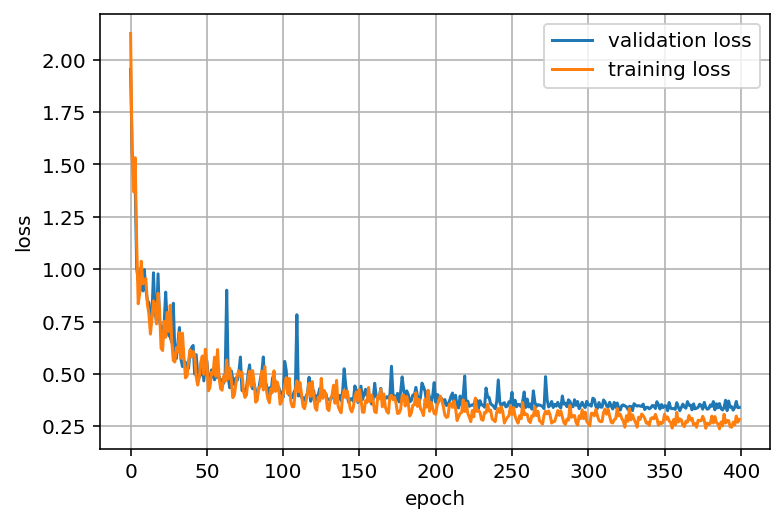

In [18]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.grid()
plt.show()

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [16]:
net=torch.load('models/best_dsb_32_depth=3_2020-03-29 19:50:33.855115.net')

/home/lalit/Desktop/01_Softwares/anaconda3/envs/stardistPytorchEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [17]:
from stardistPytorch.prediction import predict
from stardistPytorch.utils import matching_dataset

In [18]:
probThreshList=np.arange(0.1, 0.8, 0.05)
nmsThreshList=np.arange(0.1, 0.8, 0.05)

In [ ]:
avPrecisionVal=[]
for index, im in enumerate(X_val):
    avPrecisionImage=np.zeros((len(probThreshList), len(nmsThreshList)))
    for i, probThresh in enumerate(probThreshList):
        for j, nmsThresh in enumerate(nmsThreshList):
            labels, _= predict(im, net, nmsThresh, probThresh)
            score=matching_dataset([Y_val[index]], [labels])
            #print("prob", probThresh, "nms", nmsThresh, "score", score.accuracy)
            if(np.isnan(score.accuracy)):
                #print("Nan score detected")
                score.accuracy=0.0
            avPrecisionImage[i, j]= score.accuracy
    avPrecisionVal.append(avPrecisionImage)
avPrecisionVal=np.array(avPrecisionVal)

100%|██████████| 1/1 [00:00<00:00, 206.26it/s]


100%|██████████| 1/1 [00:00<00:00, 210.80it/s]


In [ ]:
avPrecisionVal_averaged=np.average(avPrecisionVal, axis=0)
i,j=np.unravel_index(np.argmax(avPrecisionVal_averaged, axis=None), avPrecisionVal_averaged.shape)
print("opt prob", probThreshList[i])
print("opt nms", nmsThreshList[j])

In [ ]:
# always remember to pass images as list to matching dataset function